Зорин Константин, БИВТ-21-17

В этом ноутбуке мы будем анализировать датасет с Kaggle [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), где нужно было предсказать длительность поездки на такси.

Для начала загрузим наш датасет и посмотрим, какие данны нам предоставлены

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

haversine - distance of the trip

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

sns.set(style="darkgrid")
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [151]:
df = pd.read_csv('train0.csv')
# test = pd.read_csv('test.csv')
df

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,haversine
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,N,455,1.498521
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,N,663,1.805507
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,N,2124,6.385098
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,N,429,1.485498
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,N,435,1.188588
...,...,...,...,...,...,...,...,...,...
1458639,1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,N,778,1.225080
1458640,1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,N,655,6.049836
1458641,1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,N,764,7.824606
1458642,1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,N,373,1.092564


In [152]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Во-первых заметим, что в тестовой выборке нет колонки 'dropoff_datetime', поэтому мы не можем обучать модель на этой фиче, и нет смысла оставлять и анализировать данную колонку.(Да и из самого trip_duration следует колонка dropoff_datetime)
Так же нам сразу следует перевести pickup_datetime в формат datetime, чтобы было удобно (и вообще возможно) анализировать данный признак. 

In [153]:
df = df.drop('dropoff_datetime', axis=1)

df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)

df.dtypes

Unnamed: 0                     int64
id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
store_and_fwd_flag            object
trip_duration                  int64
haversine                    float64
dtype: object

In [154]:
# df = df.drop('id', axis = 1)

In [155]:
from scipy import stats

Наше целевое значение находится в колонке trip_duration. Посмотрим его распределение.

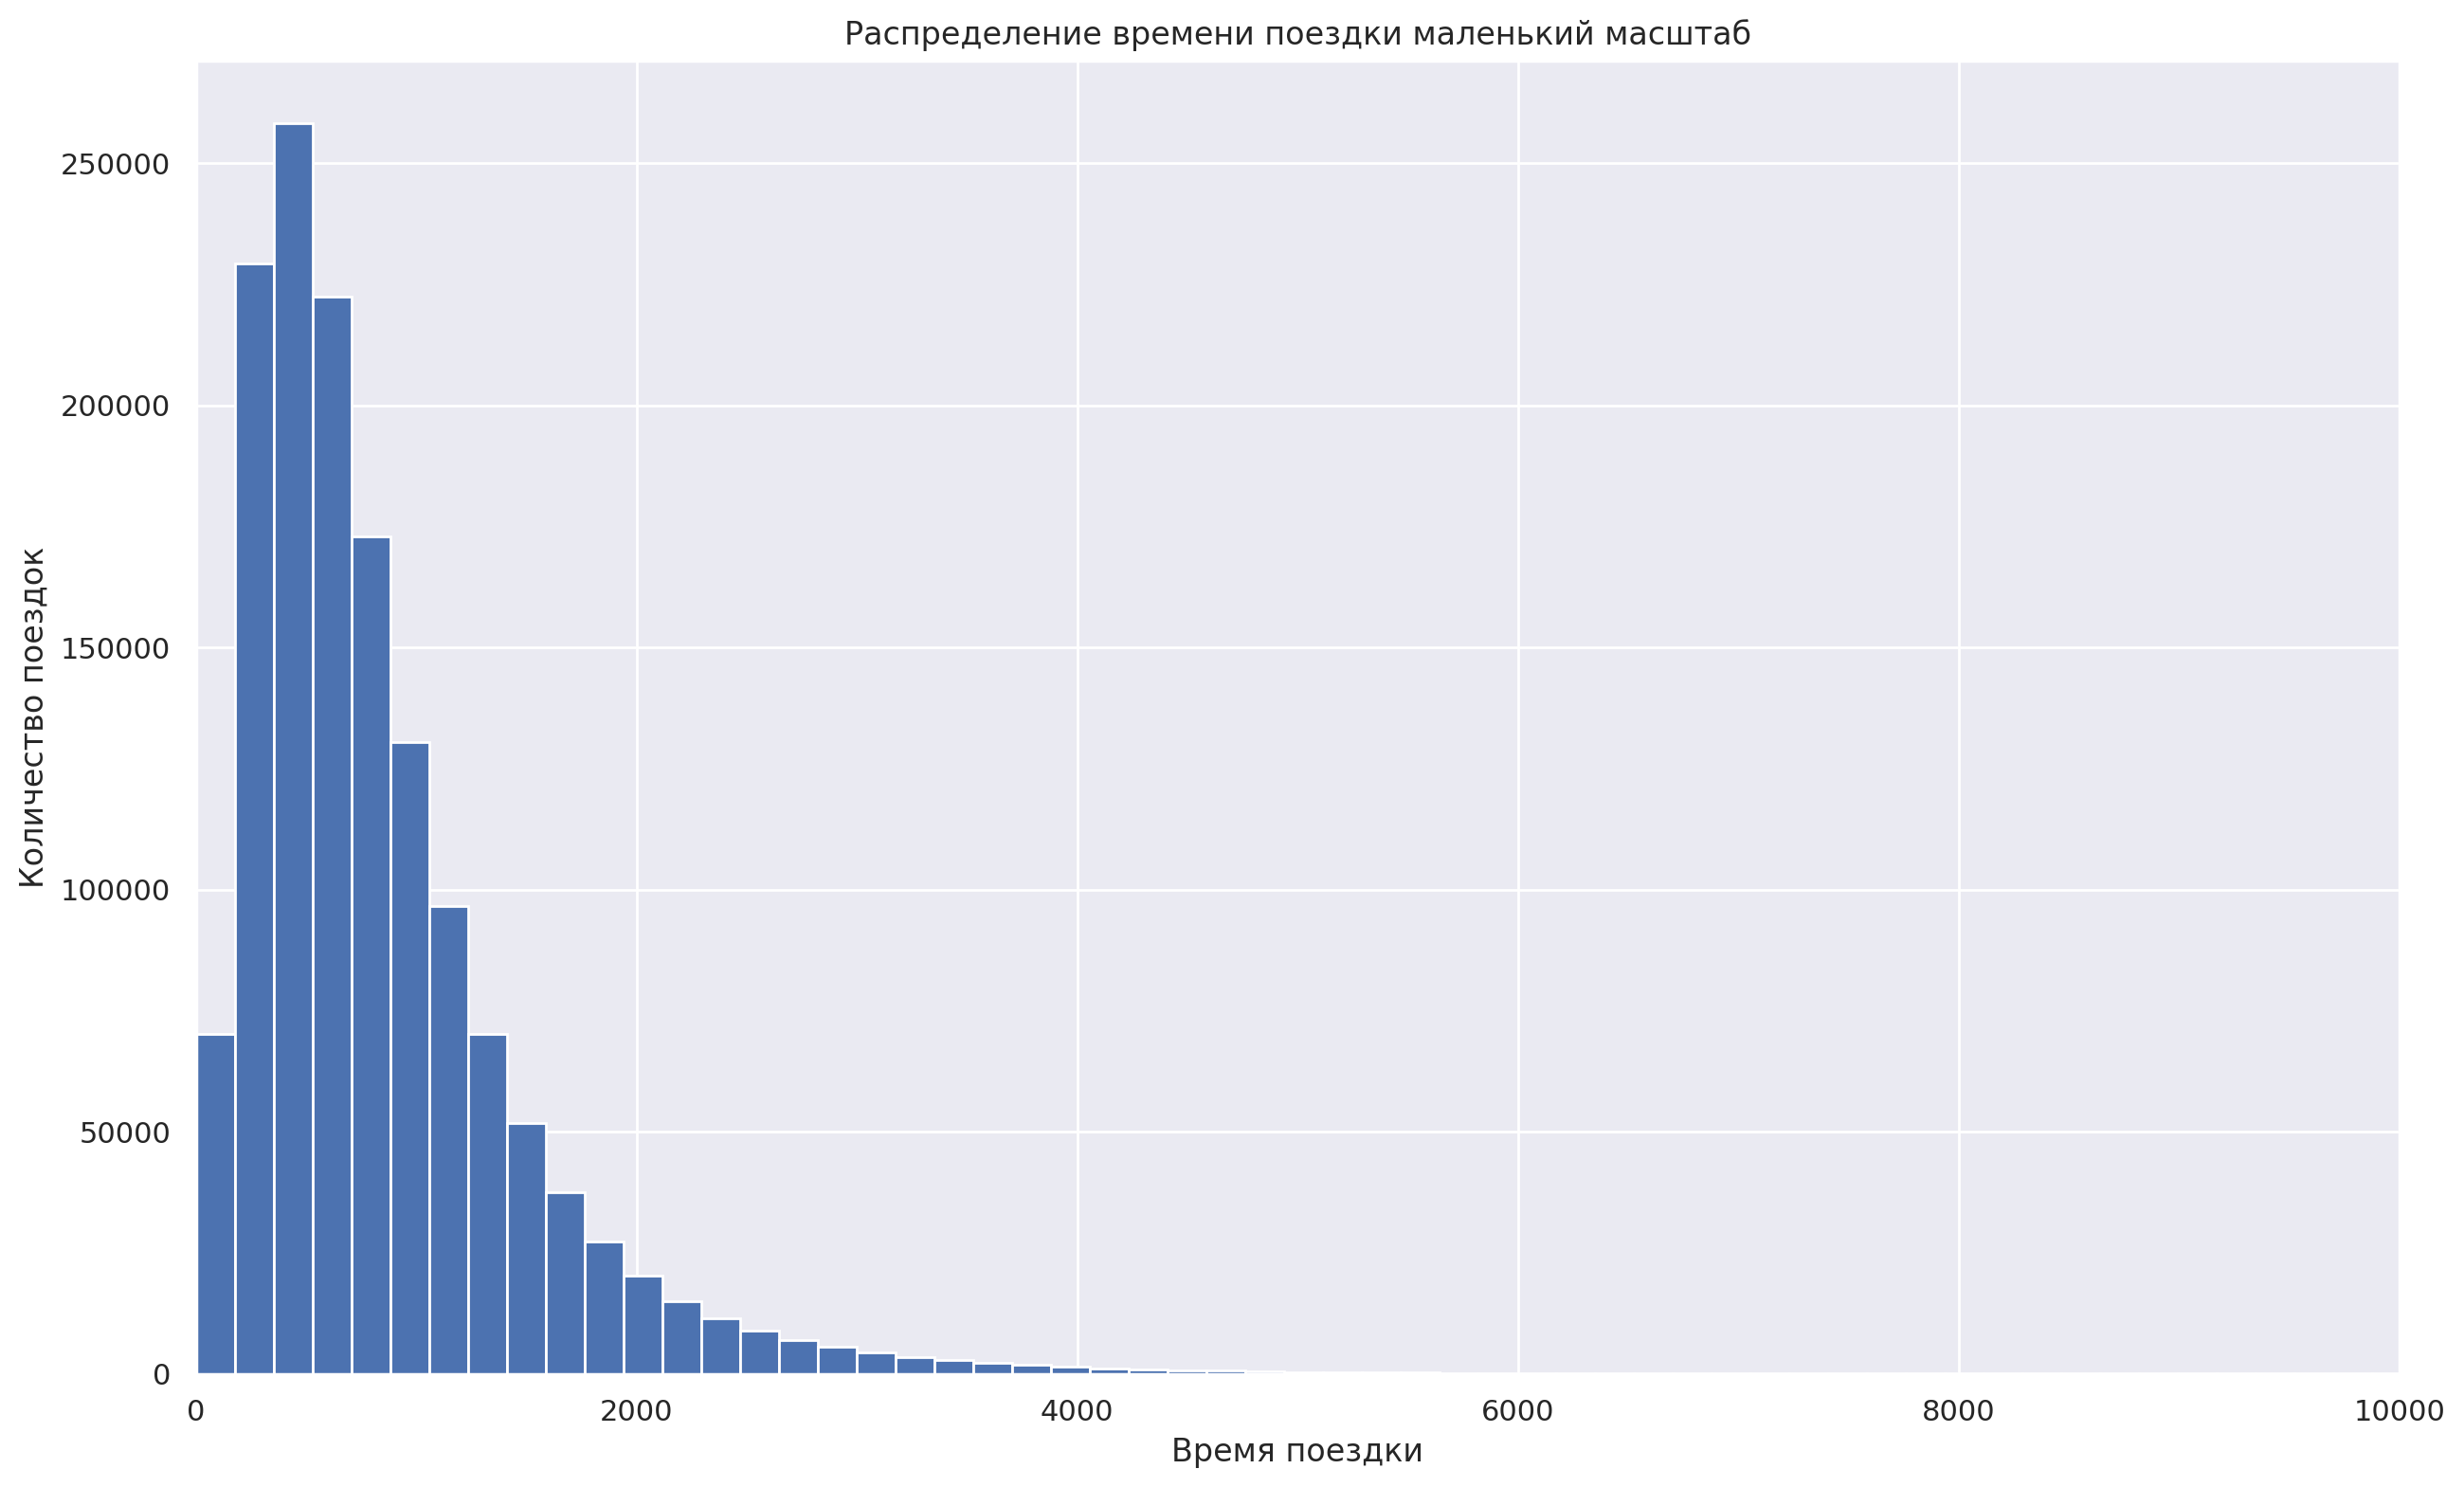

In [156]:
# plt.figure(figsize = (15,9))
plt.hist(df['trip_duration'], bins = 20000)

plt.title('Распределение времени поездки маленький масштаб')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')

plt.xlim(0,1e4)
plt.show()


Видим что распределение похоже на логнормальное.

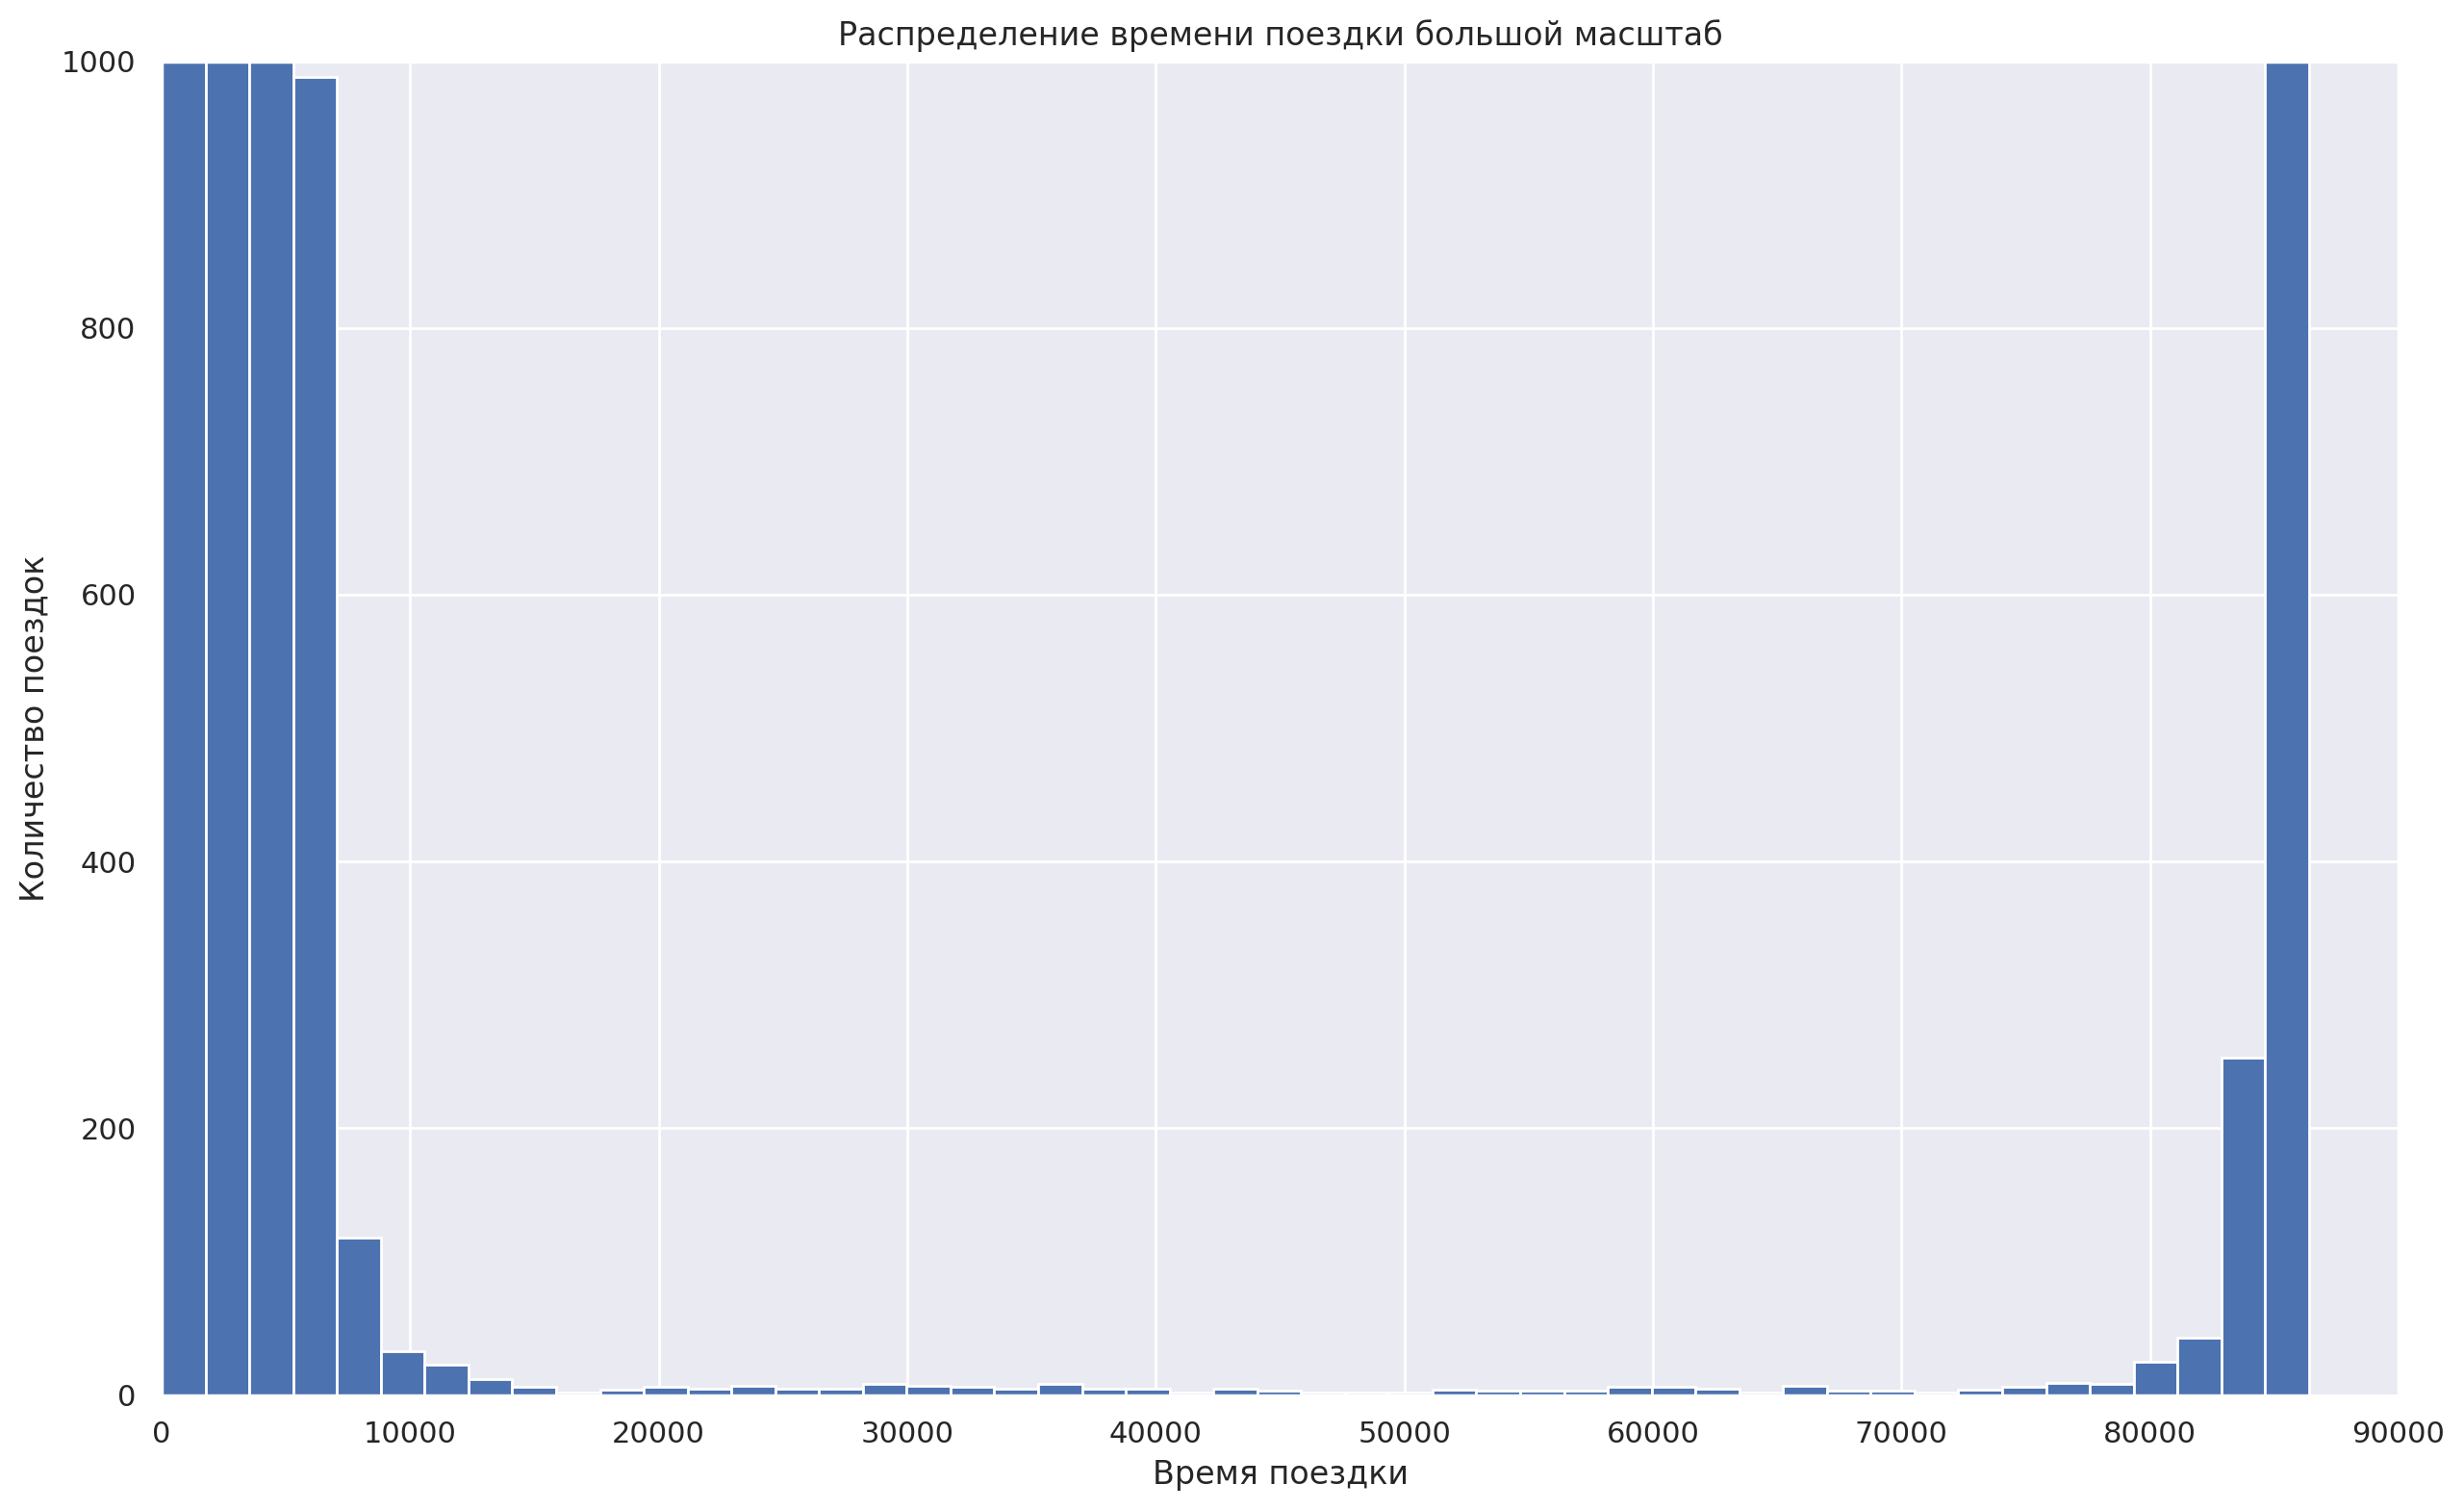

In [157]:
# plt.figure(figsize = (15,9))
plt.hist(df['trip_duration'], bins = 2000)

plt.title('Распределение времени поездки большой масштаб')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')

plt.xlim(0,9e4)
plt.ylim(0,1000)
plt.show()

Здесь видим, что есть сильно большие значения в районе 80-90к, что вряд ли является сбоем, потому что их довольно много, возможно это поездки в соседние штаты.

Если же распределение логнормальное, то понятно, что для логарифма от расстояния распределение будет нормальное


In [158]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

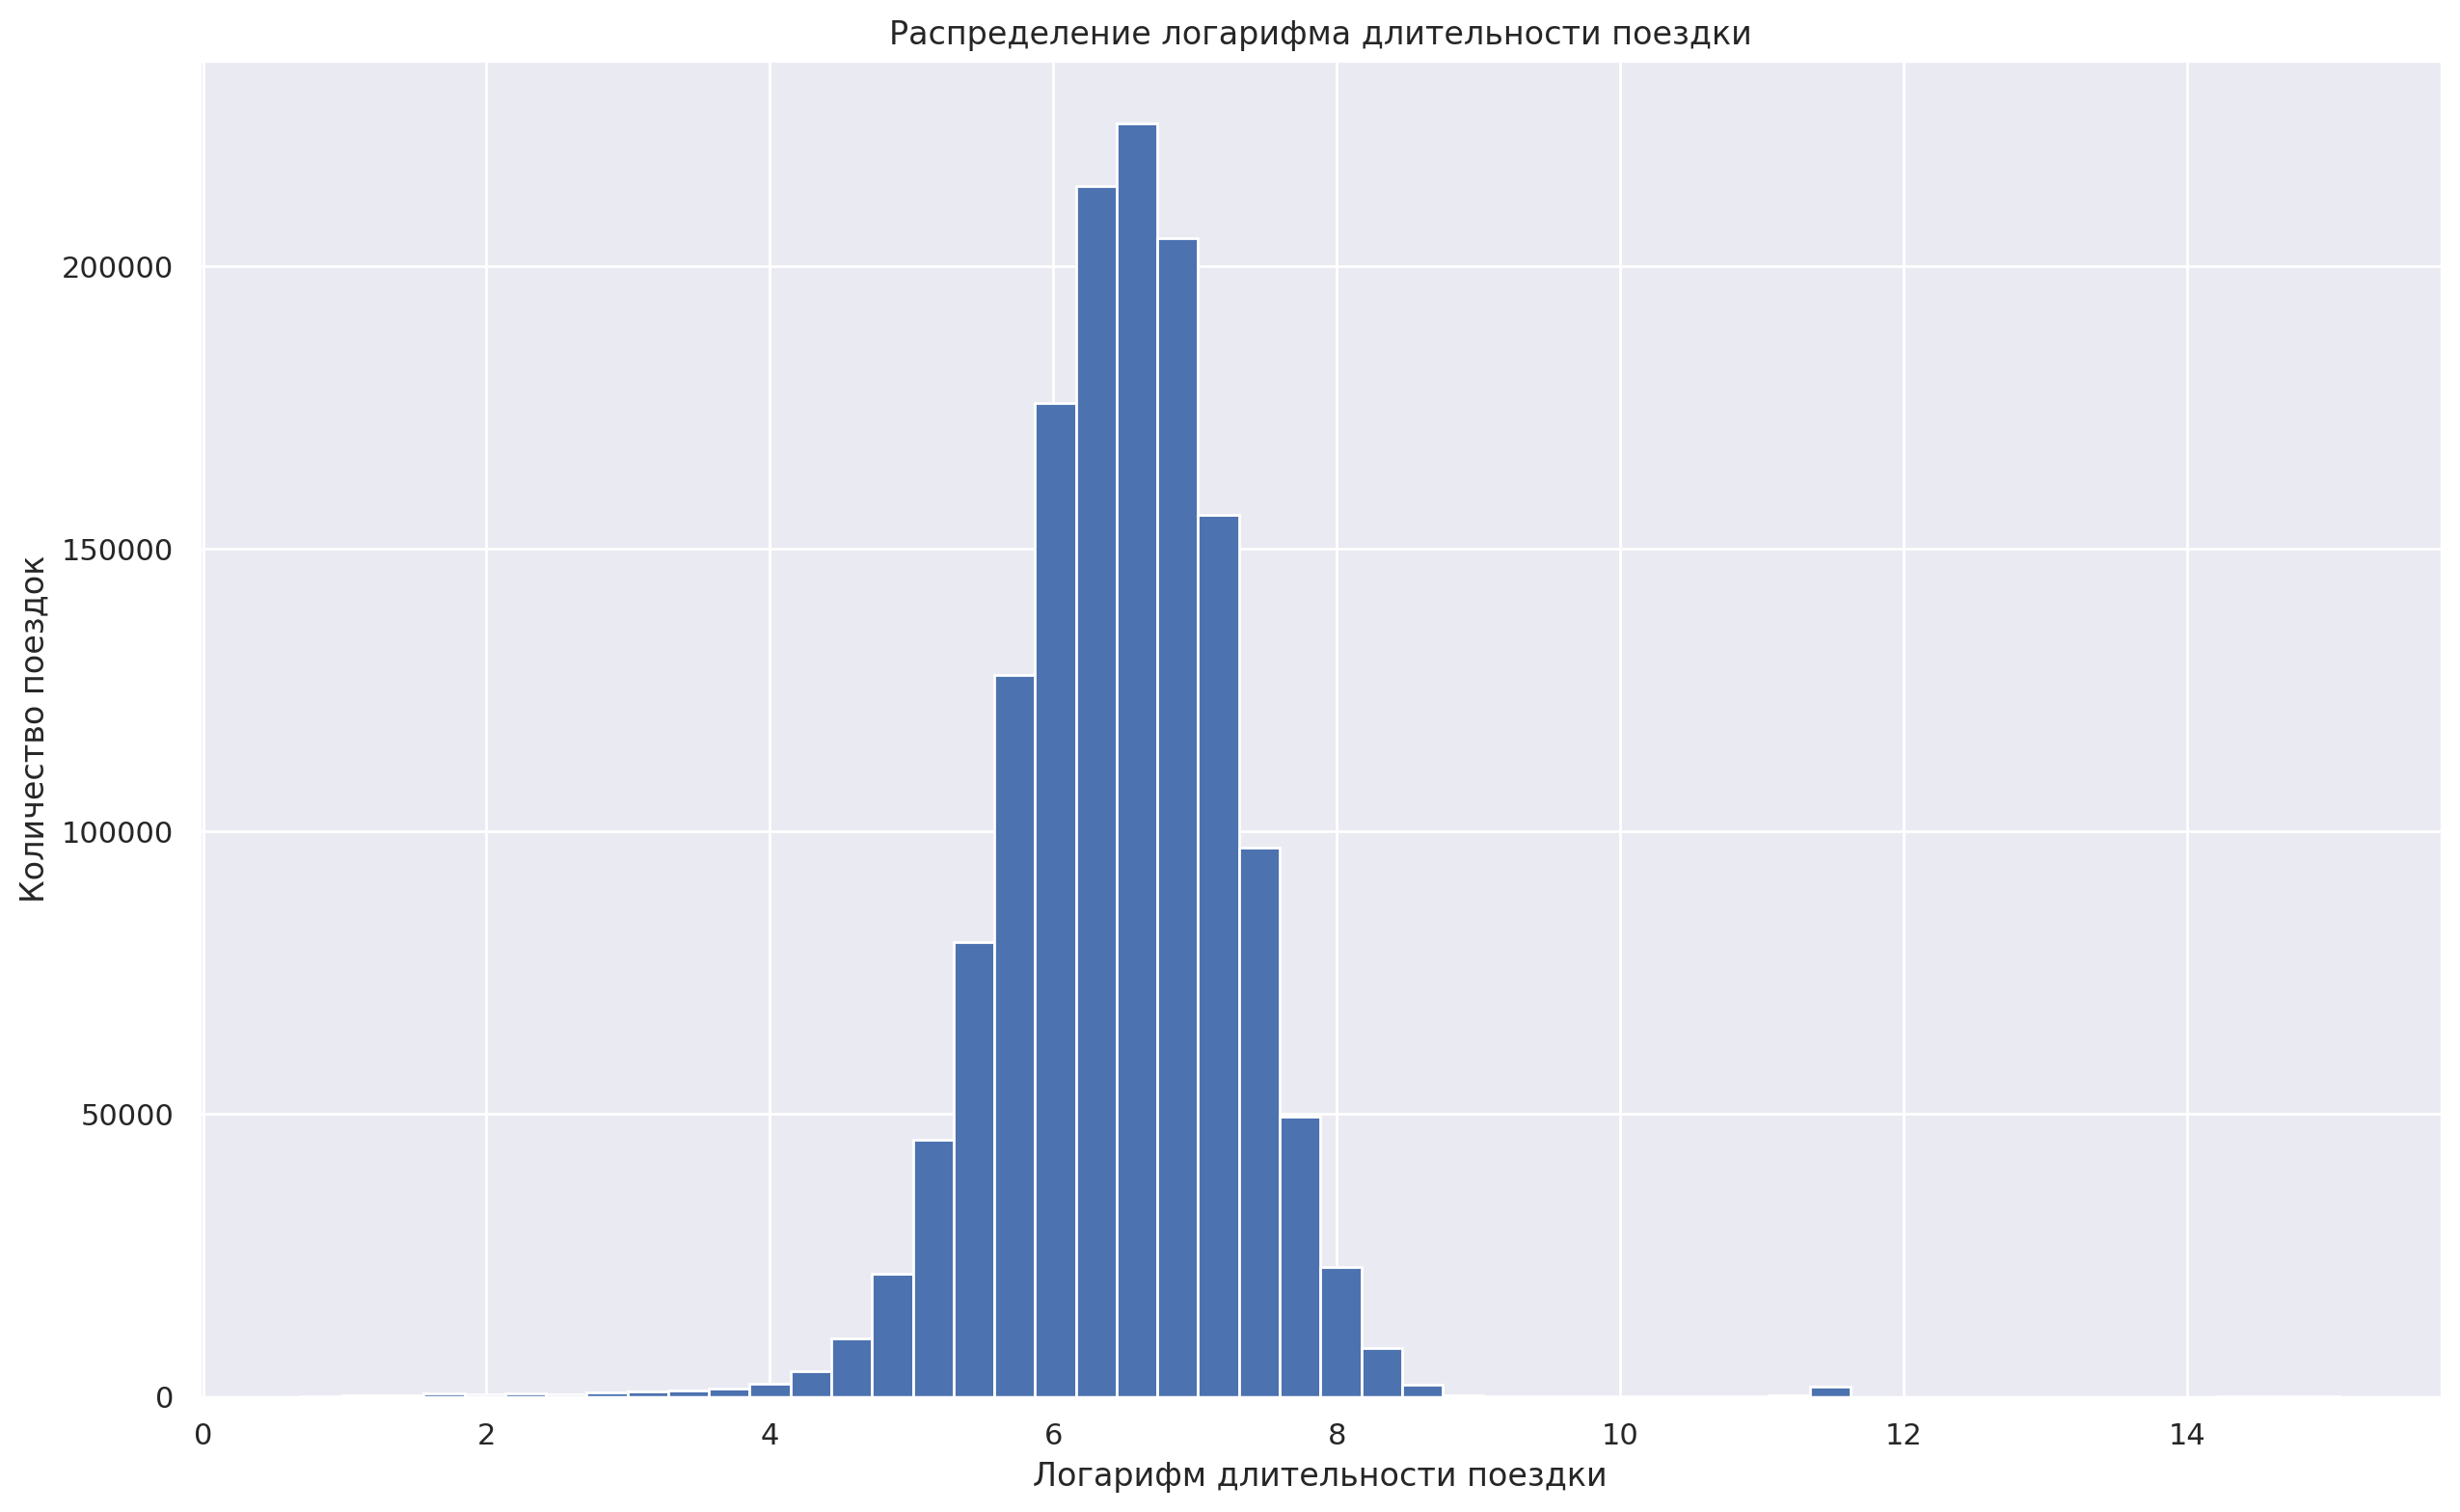

In [159]:
plt.hist(df['log_trip_duration'], bins=50)

plt.title('Распределение логарифма длительности поездки')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Количество поездок')

plt.show()

Теперь посмотрим зависимость количества поездок от дня в году


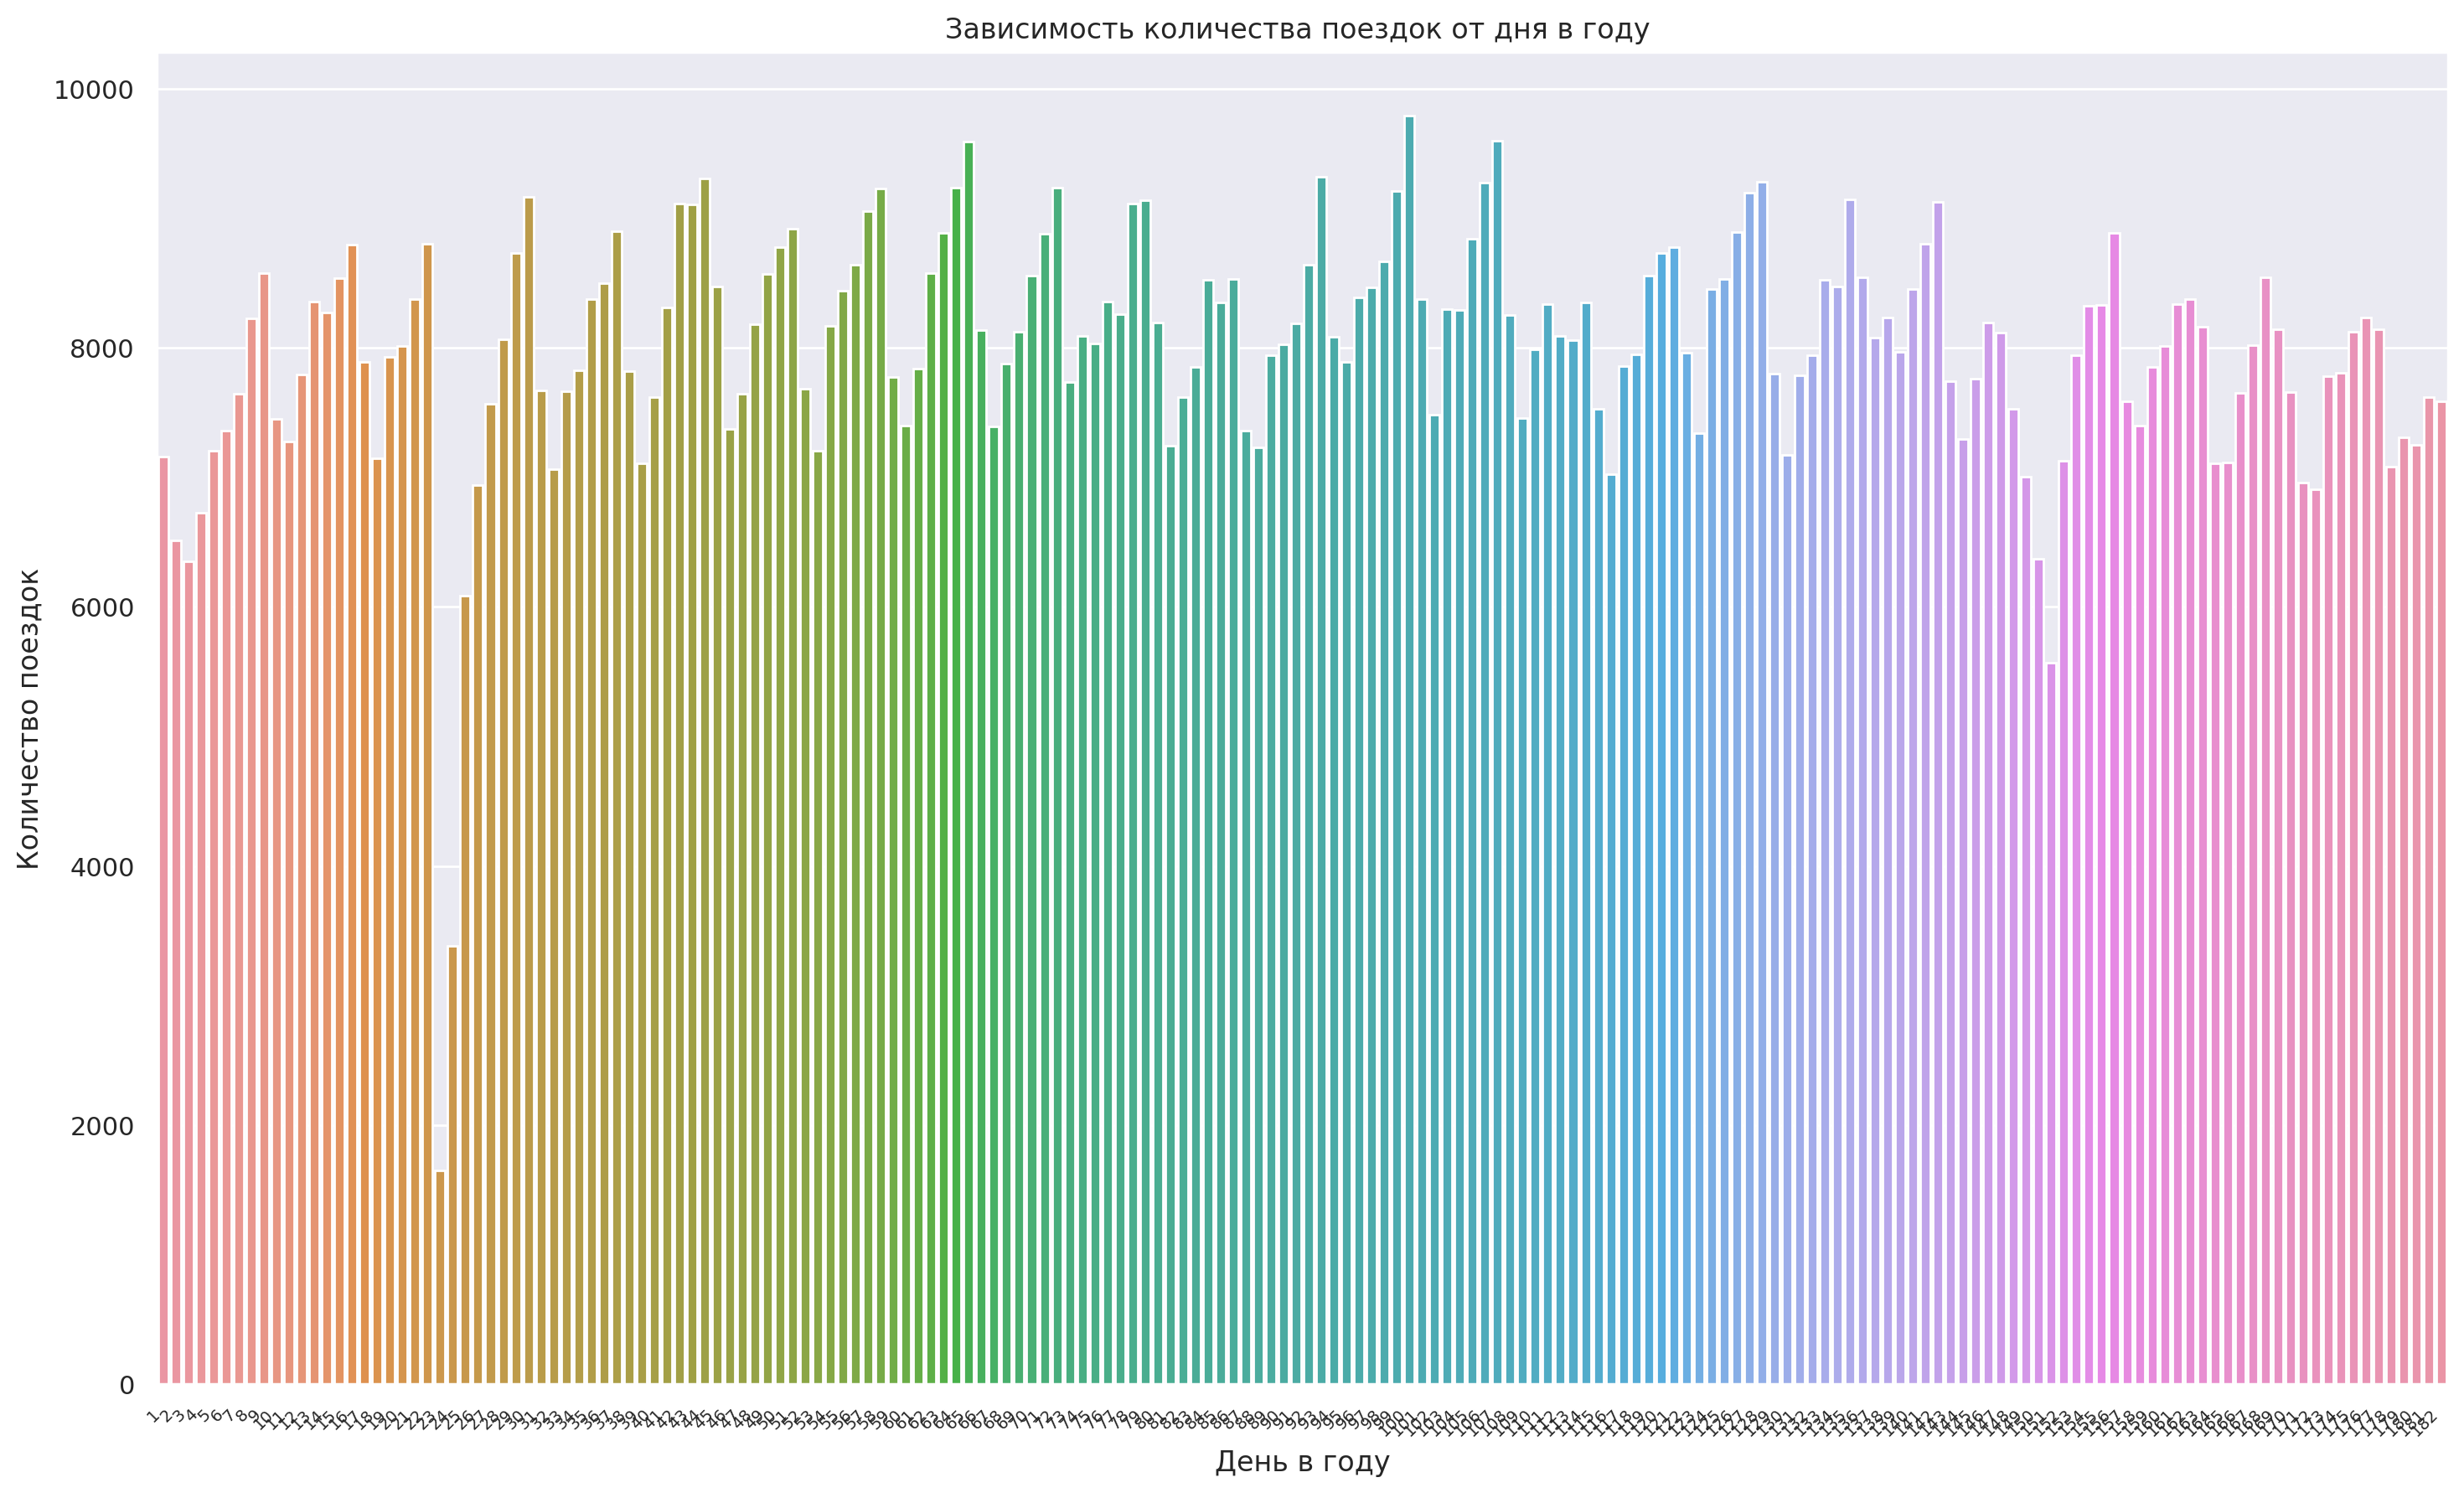

In [160]:
day = df['pickup_datetime'].dt.dayofyear.sort_values()
ax = sns.countplot(x=day)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, ha="right")
plt.tight_layout()

plt.title('Зависимость количества поездок от дня в году ')
plt.xlabel('День в году')
plt.ylabel('Количество поездок')

plt.show()

Видим аномальные просадки на 23 и 153 днях. Вероятно, это связано с терактом и ураганом, которые были в эти дни.
Добавим колонки дня поездки по номеру в году, дня в году по номеру в неделе и час поездки. (отправления)

In [161]:
df['pickup_day'] = df['pickup_datetime'].dt.dayofyear
df['pickup_day_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df

,Unnamed: 0,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,haversine,log_trip_duration,pickup_day,pickup_day_week,hour
0,0,id2875421,2,2016-03-14 17:24:55,1,N,455,1.498521,6.122493,74,0,17
1,1,id2377394,1,2016-06-12 00:43:35,1,N,663,1.805507,6.498282,164,6,0
2,2,id3858529,2,2016-01-19 11:35:24,1,N,2124,6.385098,7.661527,19,1,11
3,3,id3504673,2,2016-04-06 19:32:31,1,N,429,1.485498,6.063785,97,2,19
4,4,id2181028,2,2016-03-26 13:30:55,1,N,435,1.188588,6.077642,86,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1458639,id2376096,2,2016-04-08 13:31:04,4,N,778,1.225080,6.658011,99,4,13
1458640,1458640,id1049543,1,2016-01-10 07:35:15,1,N,655,6.049836,6.486161,10,6,7
1458641,1458641,id2304944,2,2016-04-22 06:57:41,1,N,764,7.824606,6.639876,113,4,6
1458642,1458642,id2714485,1,2016-01-05 15:56:26,1,N,373,1.092564,5.924256,5,1,15


([<matplotlib.axis.XTick at 0x7f5e82efa910>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

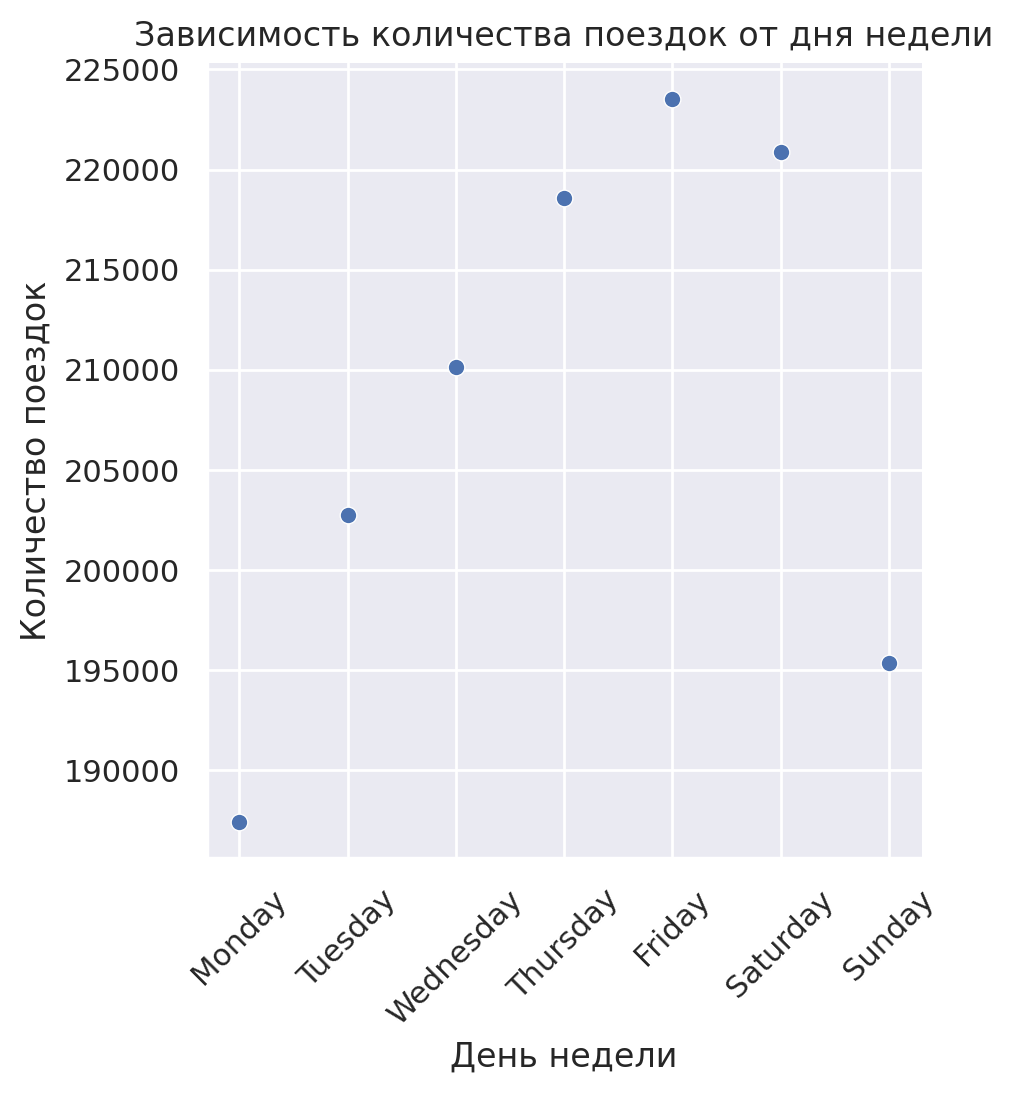

In [162]:
draw_week = df.groupby(df['pickup_datetime'].dt.dayofweek).vendor_id.count()

sns.relplot(data=draw_week) 

plt.title('Зависимость количества поездок от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')

plt.xticks(np.arange(7), rotation=45, 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Видим, что от начала до конца недели количество поездок стабильно увеличивается, но на выходных падает, что логично.


([<matplotlib.axis.XTick at 0x7f5e3b7cdaf0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

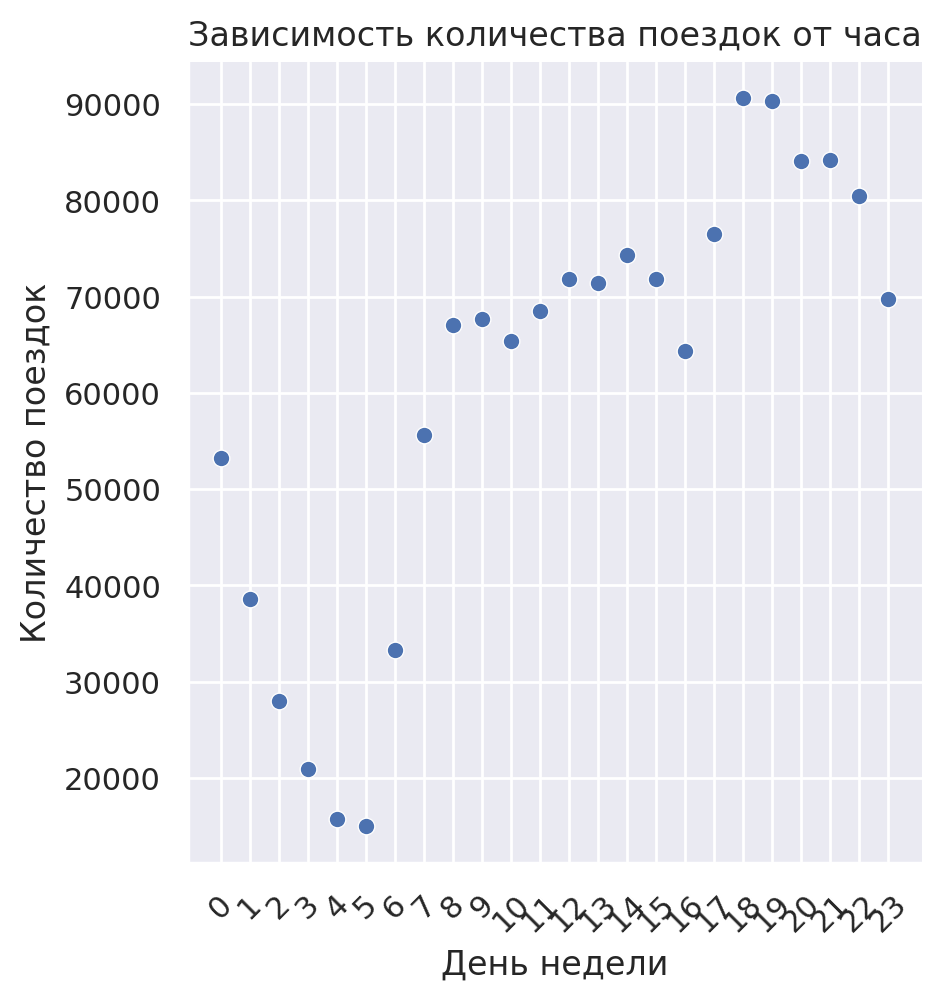

In [163]:
draw_hours = df.groupby(df['pickup_datetime'].dt.hour).vendor_id.count()

sns.relplot(data=draw_hours) 

plt.title('Зависимость количества поездок от часа')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')

plt.xticks(np.arange(24), rotation=45)

Видим, что ночью ездит меньше людей, а вечером больше, вероятно, потому что люди возвращаются с работы.

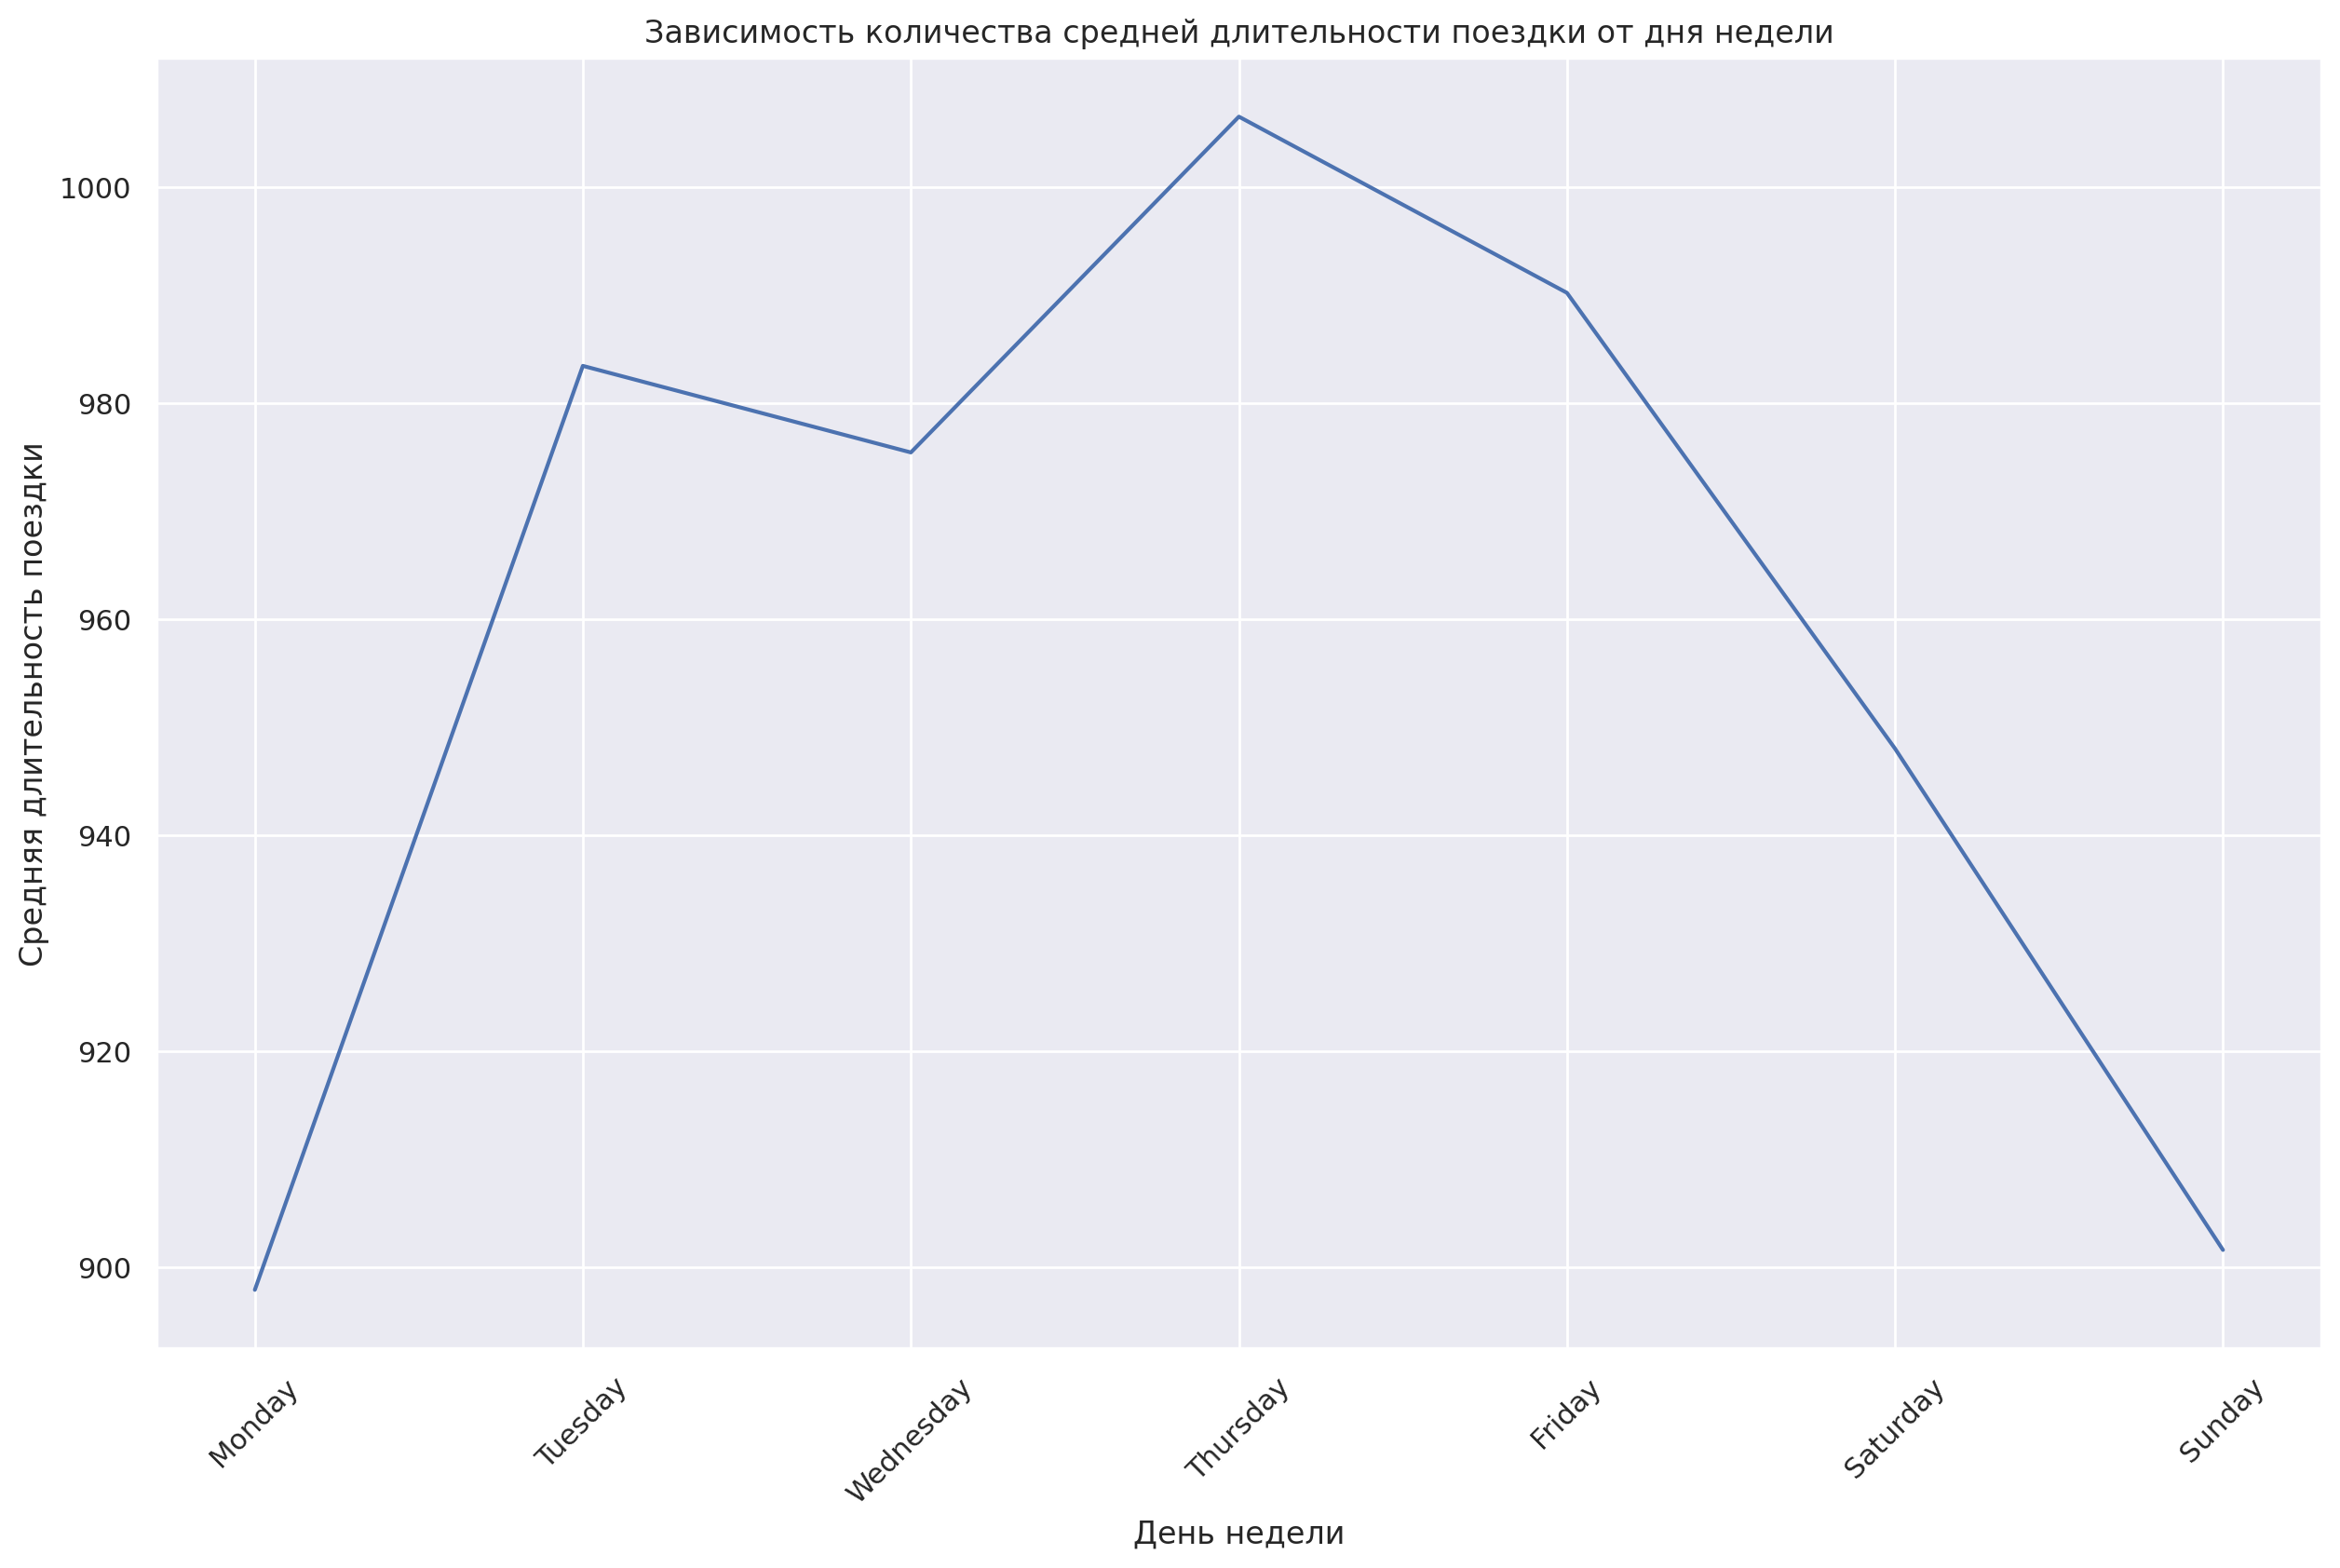

In [164]:
draw = df.groupby('pickup_day_week').trip_duration.mean().reset_index()

sns.lineplot(data=draw, x='pickup_day_week', y='trip_duration')

plt.title('Зависимость количества средней длительности поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Средняя длительность поездки')

plt.xticks(np.arange(7), rotation=45, 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()

Возникает гипотеза, что длительность поездки зависит от количества поездок, т.к. при определенном количестве возникают пробки.

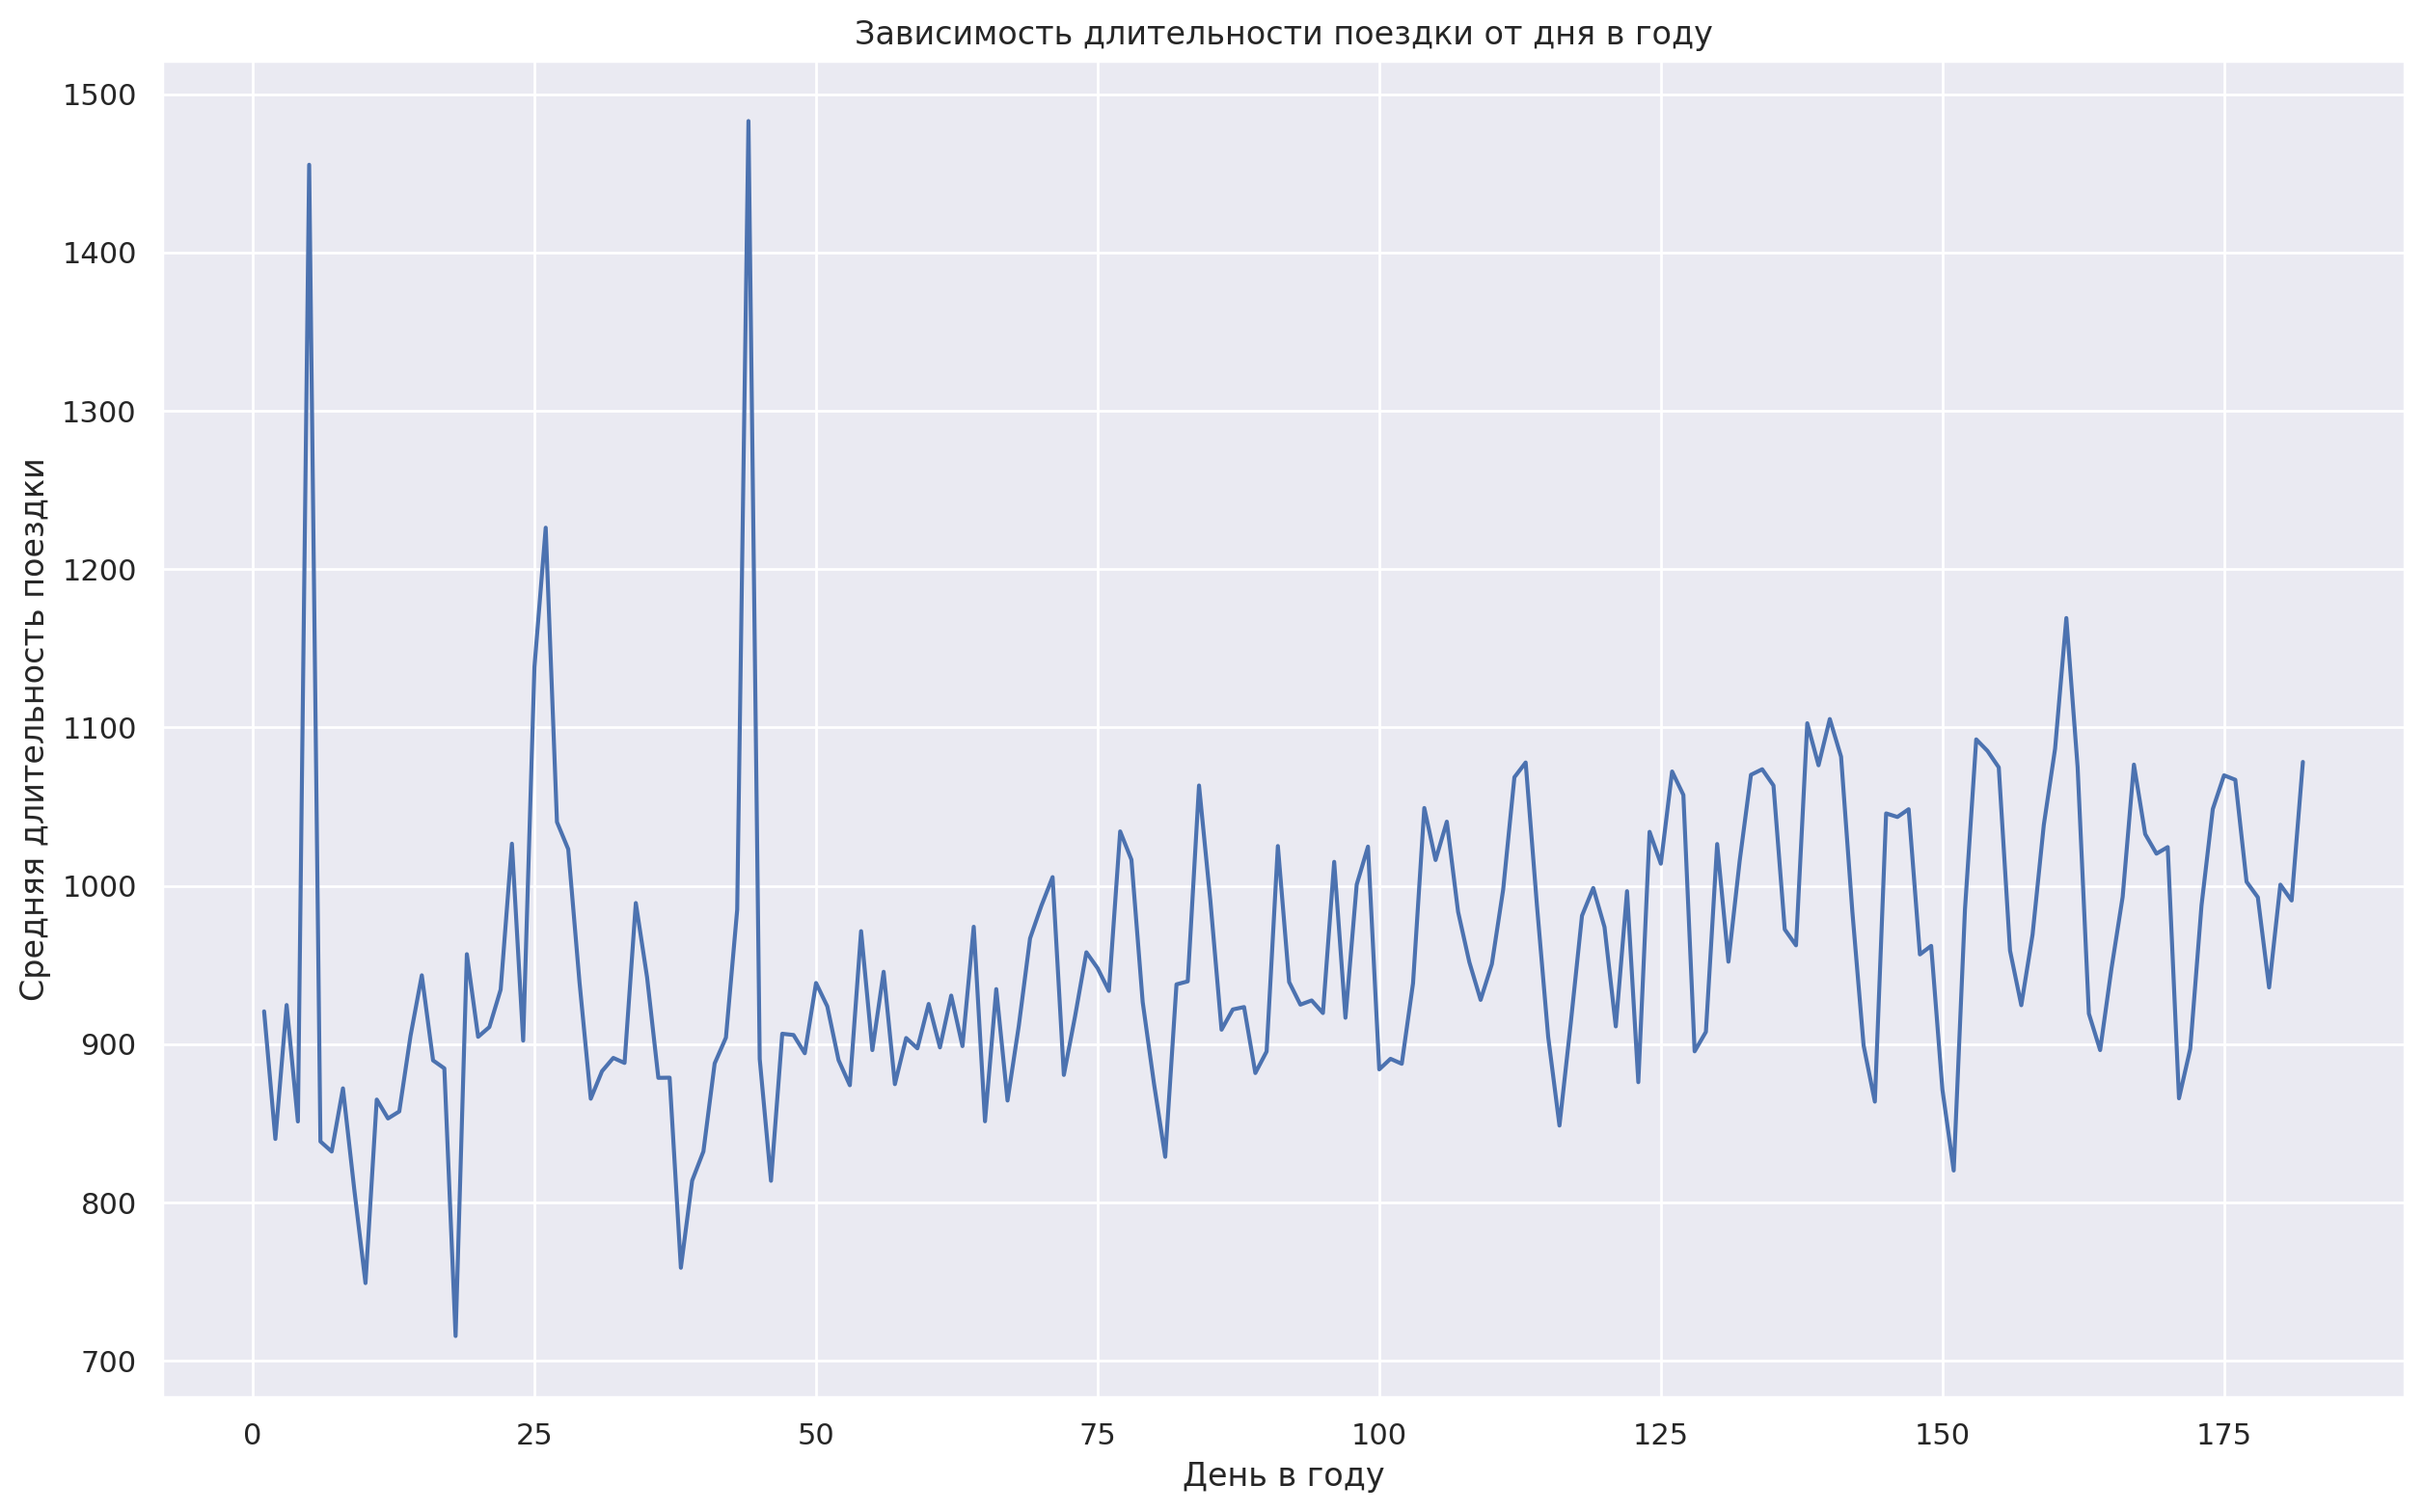

In [165]:
draw = df.groupby('pickup_day').trip_duration.mean().reset_index() 

sns.lineplot(data=draw, x='pickup_day', y='trip_duration')

plt.title('Зависимость длительности поездки от дня в году')
plt.xlabel('День в году')
plt.ylabel('Средняя длительность поездки')

plt.show()


Если не брать какие-то выбросы (возможно, какие-то праздники), то распределение получается примерно такое же, как в неделе, но чередуется

Возьмем расстояние, которое проезжает такси и рассмотрим зависимости.

In [166]:
# def haversine_array(lat1, lng1, lat2, lng2): #функция вычисления расстояния
#     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
#     AVG_EARTH_RADIUS = 6371  
#     lat = lat2 - lat1
#     lng = lng2 - lng1
#     d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
#     h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
#     return h

In [167]:
# df['haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, 
#                                   df['dropoff_latitude'].values, df['dropoff_longitude'].values)
# df.head(2)

In [168]:
# df = df.drop('pickup_latitude',axis = 1)
# df = df.drop('pickup_longitude',axis = 1)
# df  = df.drop('dropoff_latitude',axis = 1)
# df = df.drop('dropoff_longitude',axis = 1)


In [169]:
# df

In [170]:
# df.to_csv('train0.csv')

In [171]:
print('корреляция расстояния с длительностью = %.5f' % df['haversine'].corr(df['trip_duration']))

корреляция расстояния с длительностью = 0.09478


Вспоминаем, что распределение у нас логнормальное и попробуем подставить логарифм.

In [172]:
print('корреляция расстояния с логарифмом расстояния = %.5f' % df['haversine'].corr(df['log_trip_duration']))
print('корреляция логарифма расстояния с логарифмом расстояния = %.5f' % np.log1p(df['haversine'].corr(df['log_trip_duration'])))

корреляция расстояния с логарифмом расстояния = 0.57359
корреляция логарифма расстояния с логарифмом расстояния = 0.45336


In [173]:
df['log_haversine'] = np.log1p(df['haversine'])

Очевидно они коррелируют, потому что расстояние самый сильный признак для длительности поездки, но, зато, убедились, что сильнее было работать с логарифмом длительности

Мы ещё совсем не рассматривали признаки vendor_id, store_and_fwd_flag и passenger_count. Проанализируем их


In [174]:
df[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

Закодируем текстовые признаки.

In [175]:
df.loc[(df['vendor_id']==1), 'vendor_id'] = 0
df.loc[(df['vendor_id']==2), 'vendor_id'] = 1

df.loc[(df['store_and_fwd_flag']=='N'), 'store_and_fwd_flag'] = 0
df.loc[(df['store_and_fwd_flag']=='Y'), 'store_and_fwd_flag'] = 1

In [176]:
df.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,haversine,log_trip_duration,pickup_day,pickup_day_week,hour,log_haversine
0,0,id2875421,1,2016-03-14 17:24:55,1,0,455,1.498521,6.122493,74,0,17,0.915699
1,1,id2377394,0,2016-06-12 00:43:35,1,0,663,1.805507,6.498282,164,6,0,1.031584
2,2,id3858529,1,2016-01-19 11:35:24,1,0,2124,6.385098,7.661527,19,1,11,1.999464
3,3,id3504673,1,2016-04-06 19:32:31,1,0,429,1.485498,6.063785,97,2,19,0.910473
4,4,id2181028,1,2016-03-26 13:30:55,1,0,435,1.188588,6.077642,86,5,13,0.783257


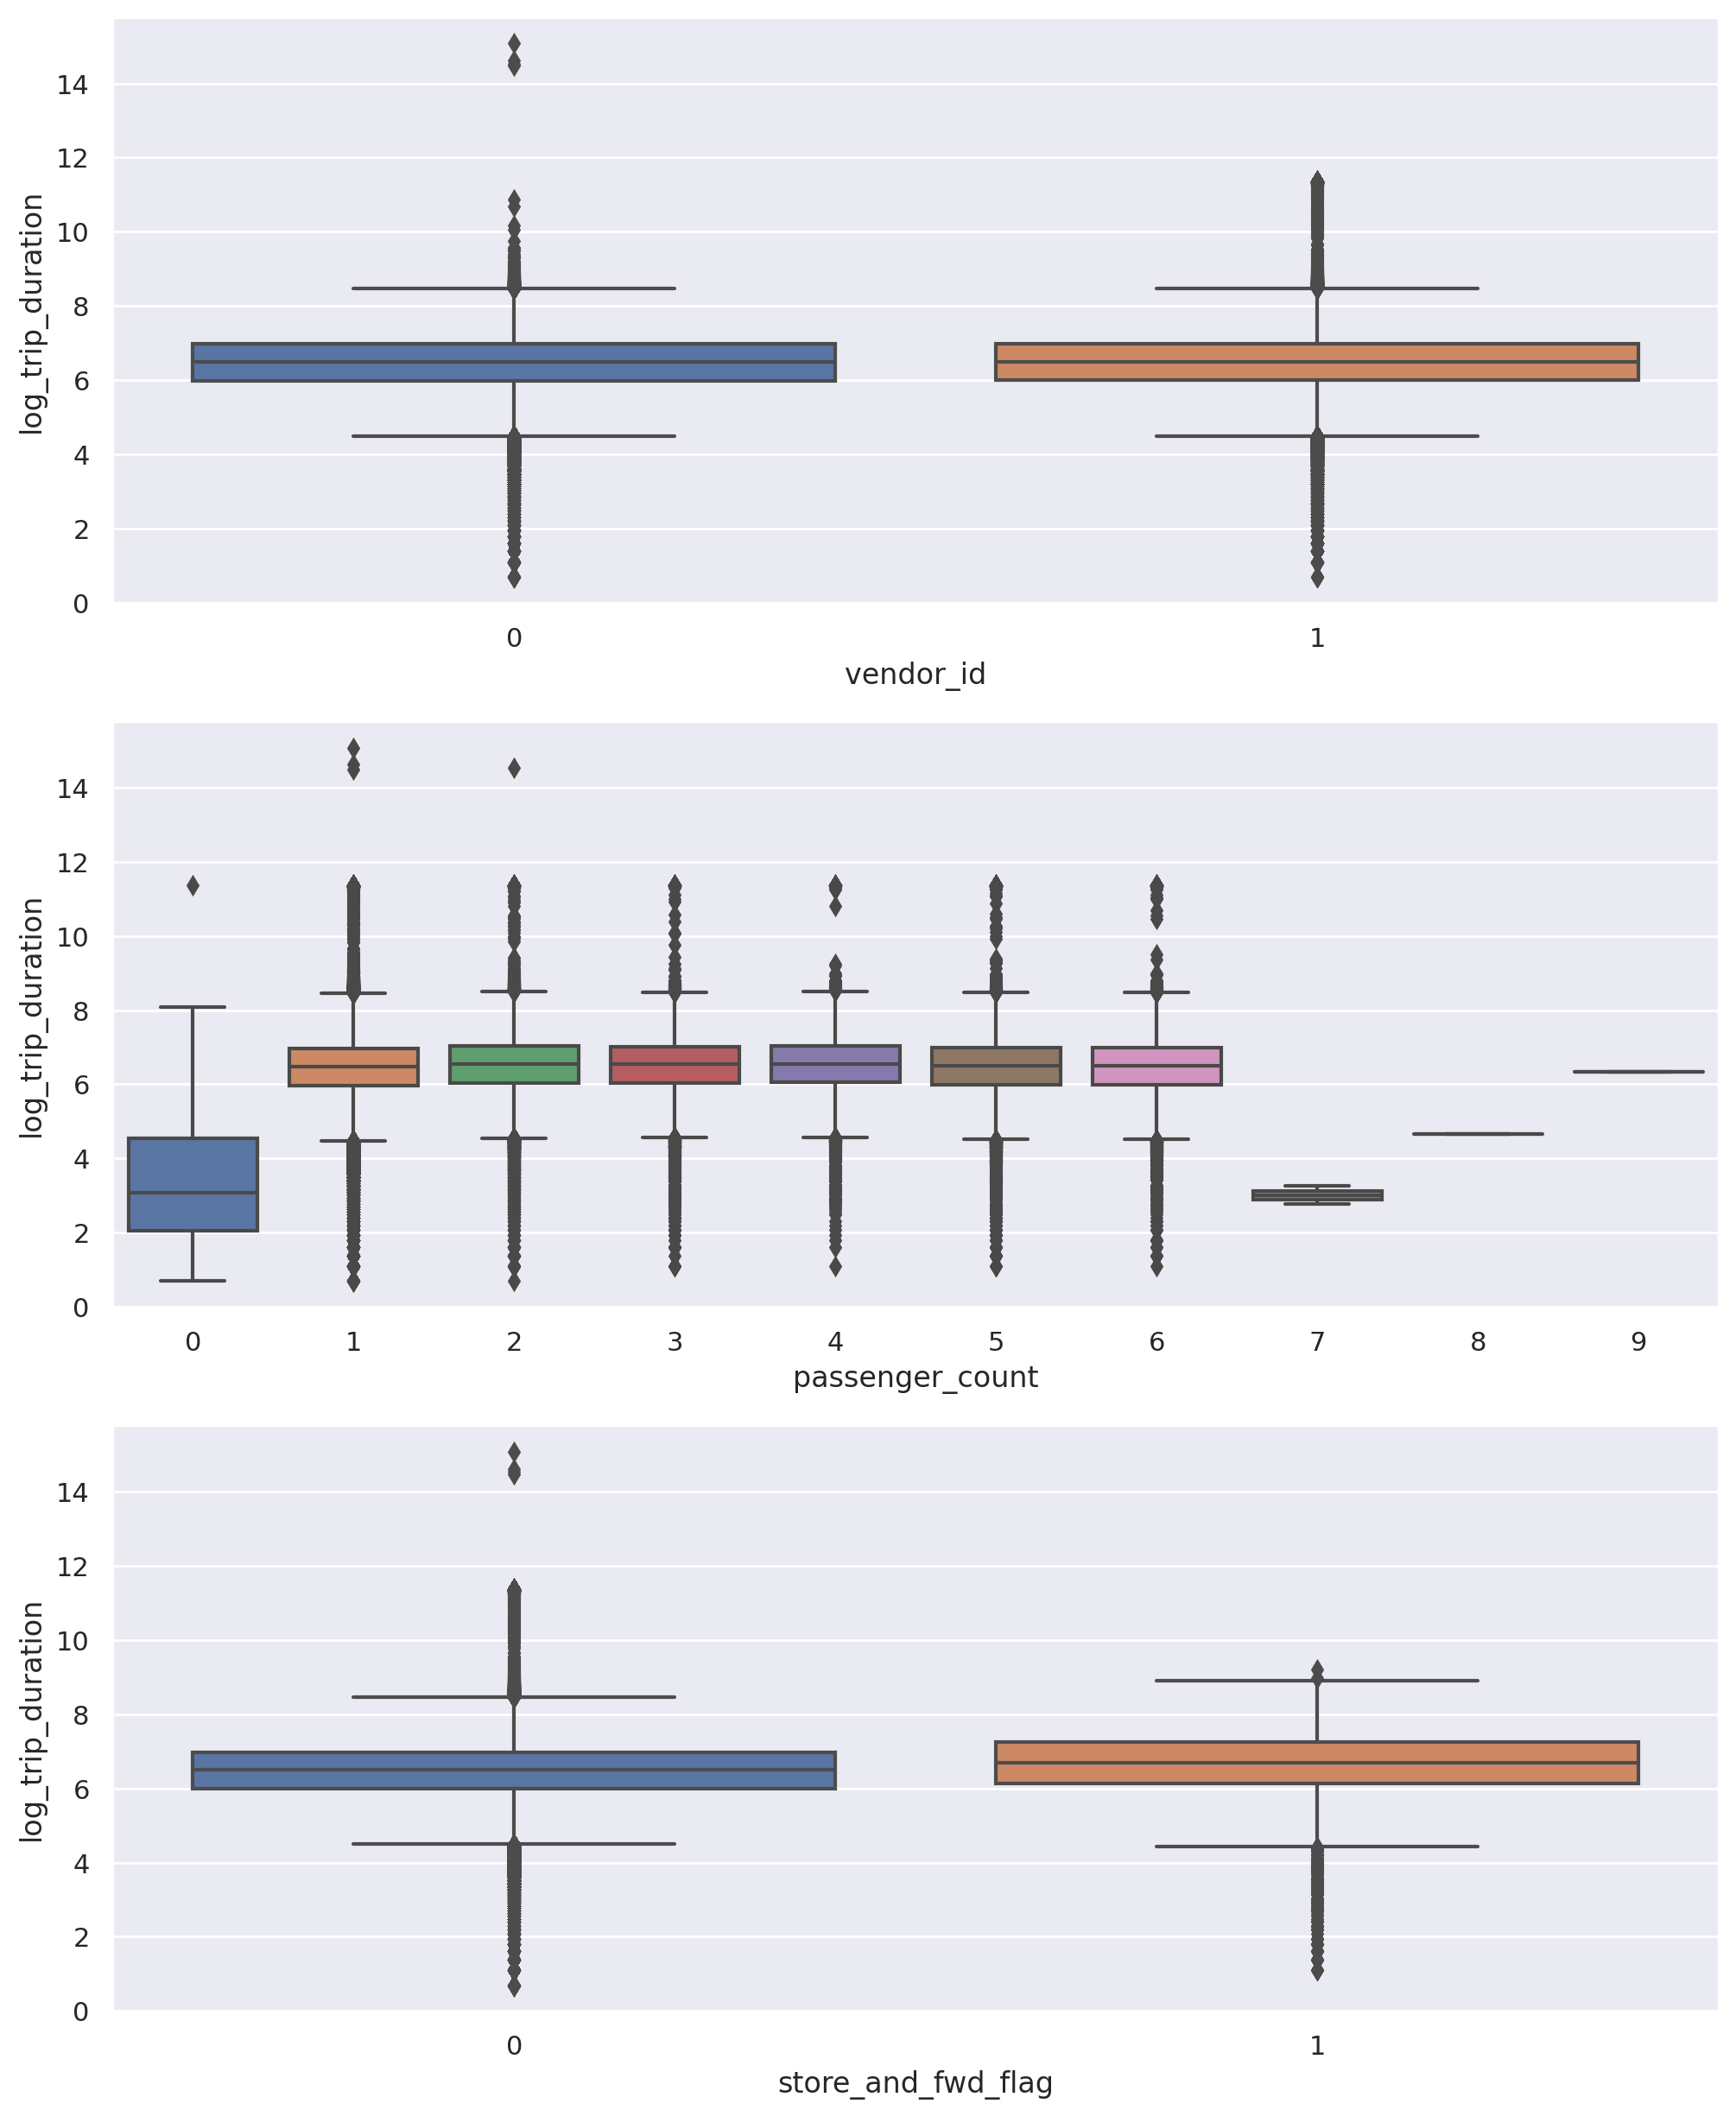

In [177]:
plt.figure(figsize=(12,15))

plt.subplot(3, 1, 1)
sns.boxplot(df, x='vendor_id', y='log_trip_duration')

plt.subplot(3, 1, 2)
sns.boxplot(df, x='passenger_count', y='log_trip_duration')

plt.subplot(3, 1, 3)
sns.boxplot(df, x='store_and_fwd_flag', y='log_trip_duration')
    

plt.show()

Видим, что store_and_fwd_flag и vendor_id имеют схожие рапспределения у разных групп, поэтому можрно сказать, что это не сильно влияет на количество модели.
По passenger_count, можно сделать вывод, что 1,2,3,4,5,6 тоже распределены примерно одинаково, а вот 7,8,9 и 0 - выбросы и их стоит исключить.

In [178]:
df.head(1)

,Unnamed: 0,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,haversine,log_trip_duration,pickup_day,pickup_day_week,hour,log_haversine
0,0,id2875421,1,2016-03-14 17:24:55,1,0,455,1.498521,6.122493,74,0,17,0.915699


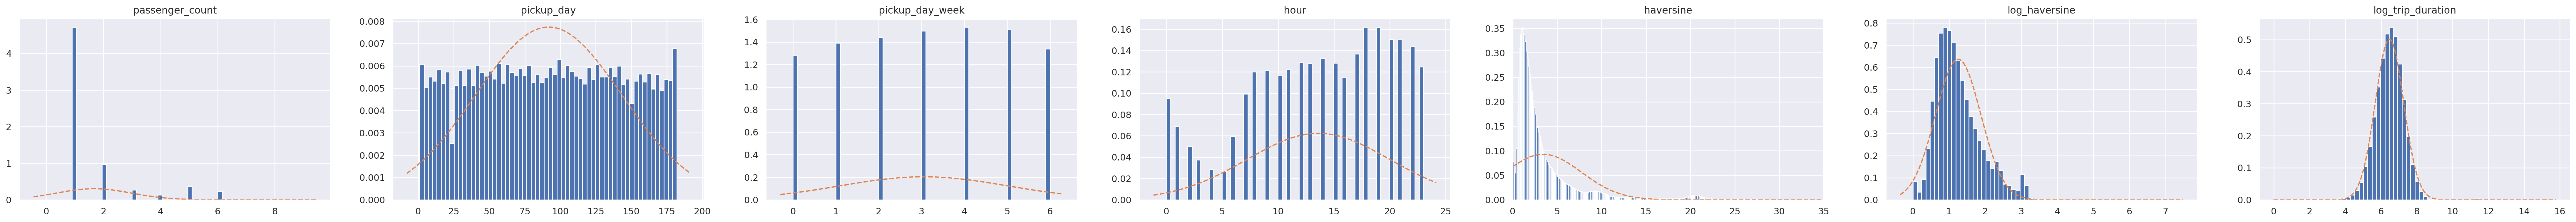

In [179]:
keys = ['passenger_count', 'pickup_day', 'pickup_day_week','hour','haversine','log_haversine','log_trip_duration']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    if key == 'haversine':
        ax.hist(df[key], density=True, bins=10000)
        ax.set_xlim([0, 35])
    else:
        ax.hist(df[key], density=True, bins=60)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 1000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

Про дату было вполне очевидно, потому что дата не количественный признак. Как мы предпологали ранее, log_trip_duration будет распределен нормально,я ещё предположил, что haversine распределен логнормально, и, следовательно, log_haversine будет распределен нормально, это почти так

In [180]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy import stats

# # keys = ['passenger_count', 'pickup_day', 'pickup_day_week', 'hour', 'haversine']

# fig, axes = plt.subplots(ncols=len(keys), figsize=(8 * len(keys), 4))
# axes = axes.flatten()

# for key, ax in zip(keys, axes):
#     samples = df[key]

#     loc = samples.mean()
#     scale = samples.std()

#     x = stats.norm.ppf(np.linspace(0, 1, 101), loc=0, scale=1)
#     y = np.percentile(samples, np.linspace(0, 100, 101))

#     ax.scatter(x, y, s=5)
#     ax.plot(x, x, color='C1', linestyle='dashed')

#     ax.set_title(key)
#     ax.set_xlabel('теоретические квантили')
#     ax.set_ylabel('квантили выборки')

In [181]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

passenger_count
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.852749539983711
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9133263496781943
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9668610024104579

pickup_day
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.5887269272008797
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		1.0
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0

pickup_day_week
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.5985771716745142
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		1.0
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0

hour
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6607876904851355
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9634948623516087
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0

haversine
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9018142877905782
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.956335473

Убеждаемся, что логарифм длительности поездки и логарифм расстояния распределены почти нормально, а количество пассажиров не совсем
.

In [182]:
def sum_of_squares(samples: np.ndarray) -> float:
    return ((samples - samples.mean()) ** 2).sum()

Считаем регрессию и видим, что зависимости скорее всего нет

In [183]:
ones = np.ones((1458644,1))
x_pot = np.hstack((ones, df['passenger_count'].values.reshape(1458644,1)))
XTX = x_pot.T.dot(x_pot)
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x_pot.T).dot(df['trip_duration'])
z = x_pot.dot(b)
e = df['trip_duration'] - z
R = 1 - sum_of_squares(e) / sum_of_squares(np.array(df['trip_duration']))
R

7.175763583744388e-05

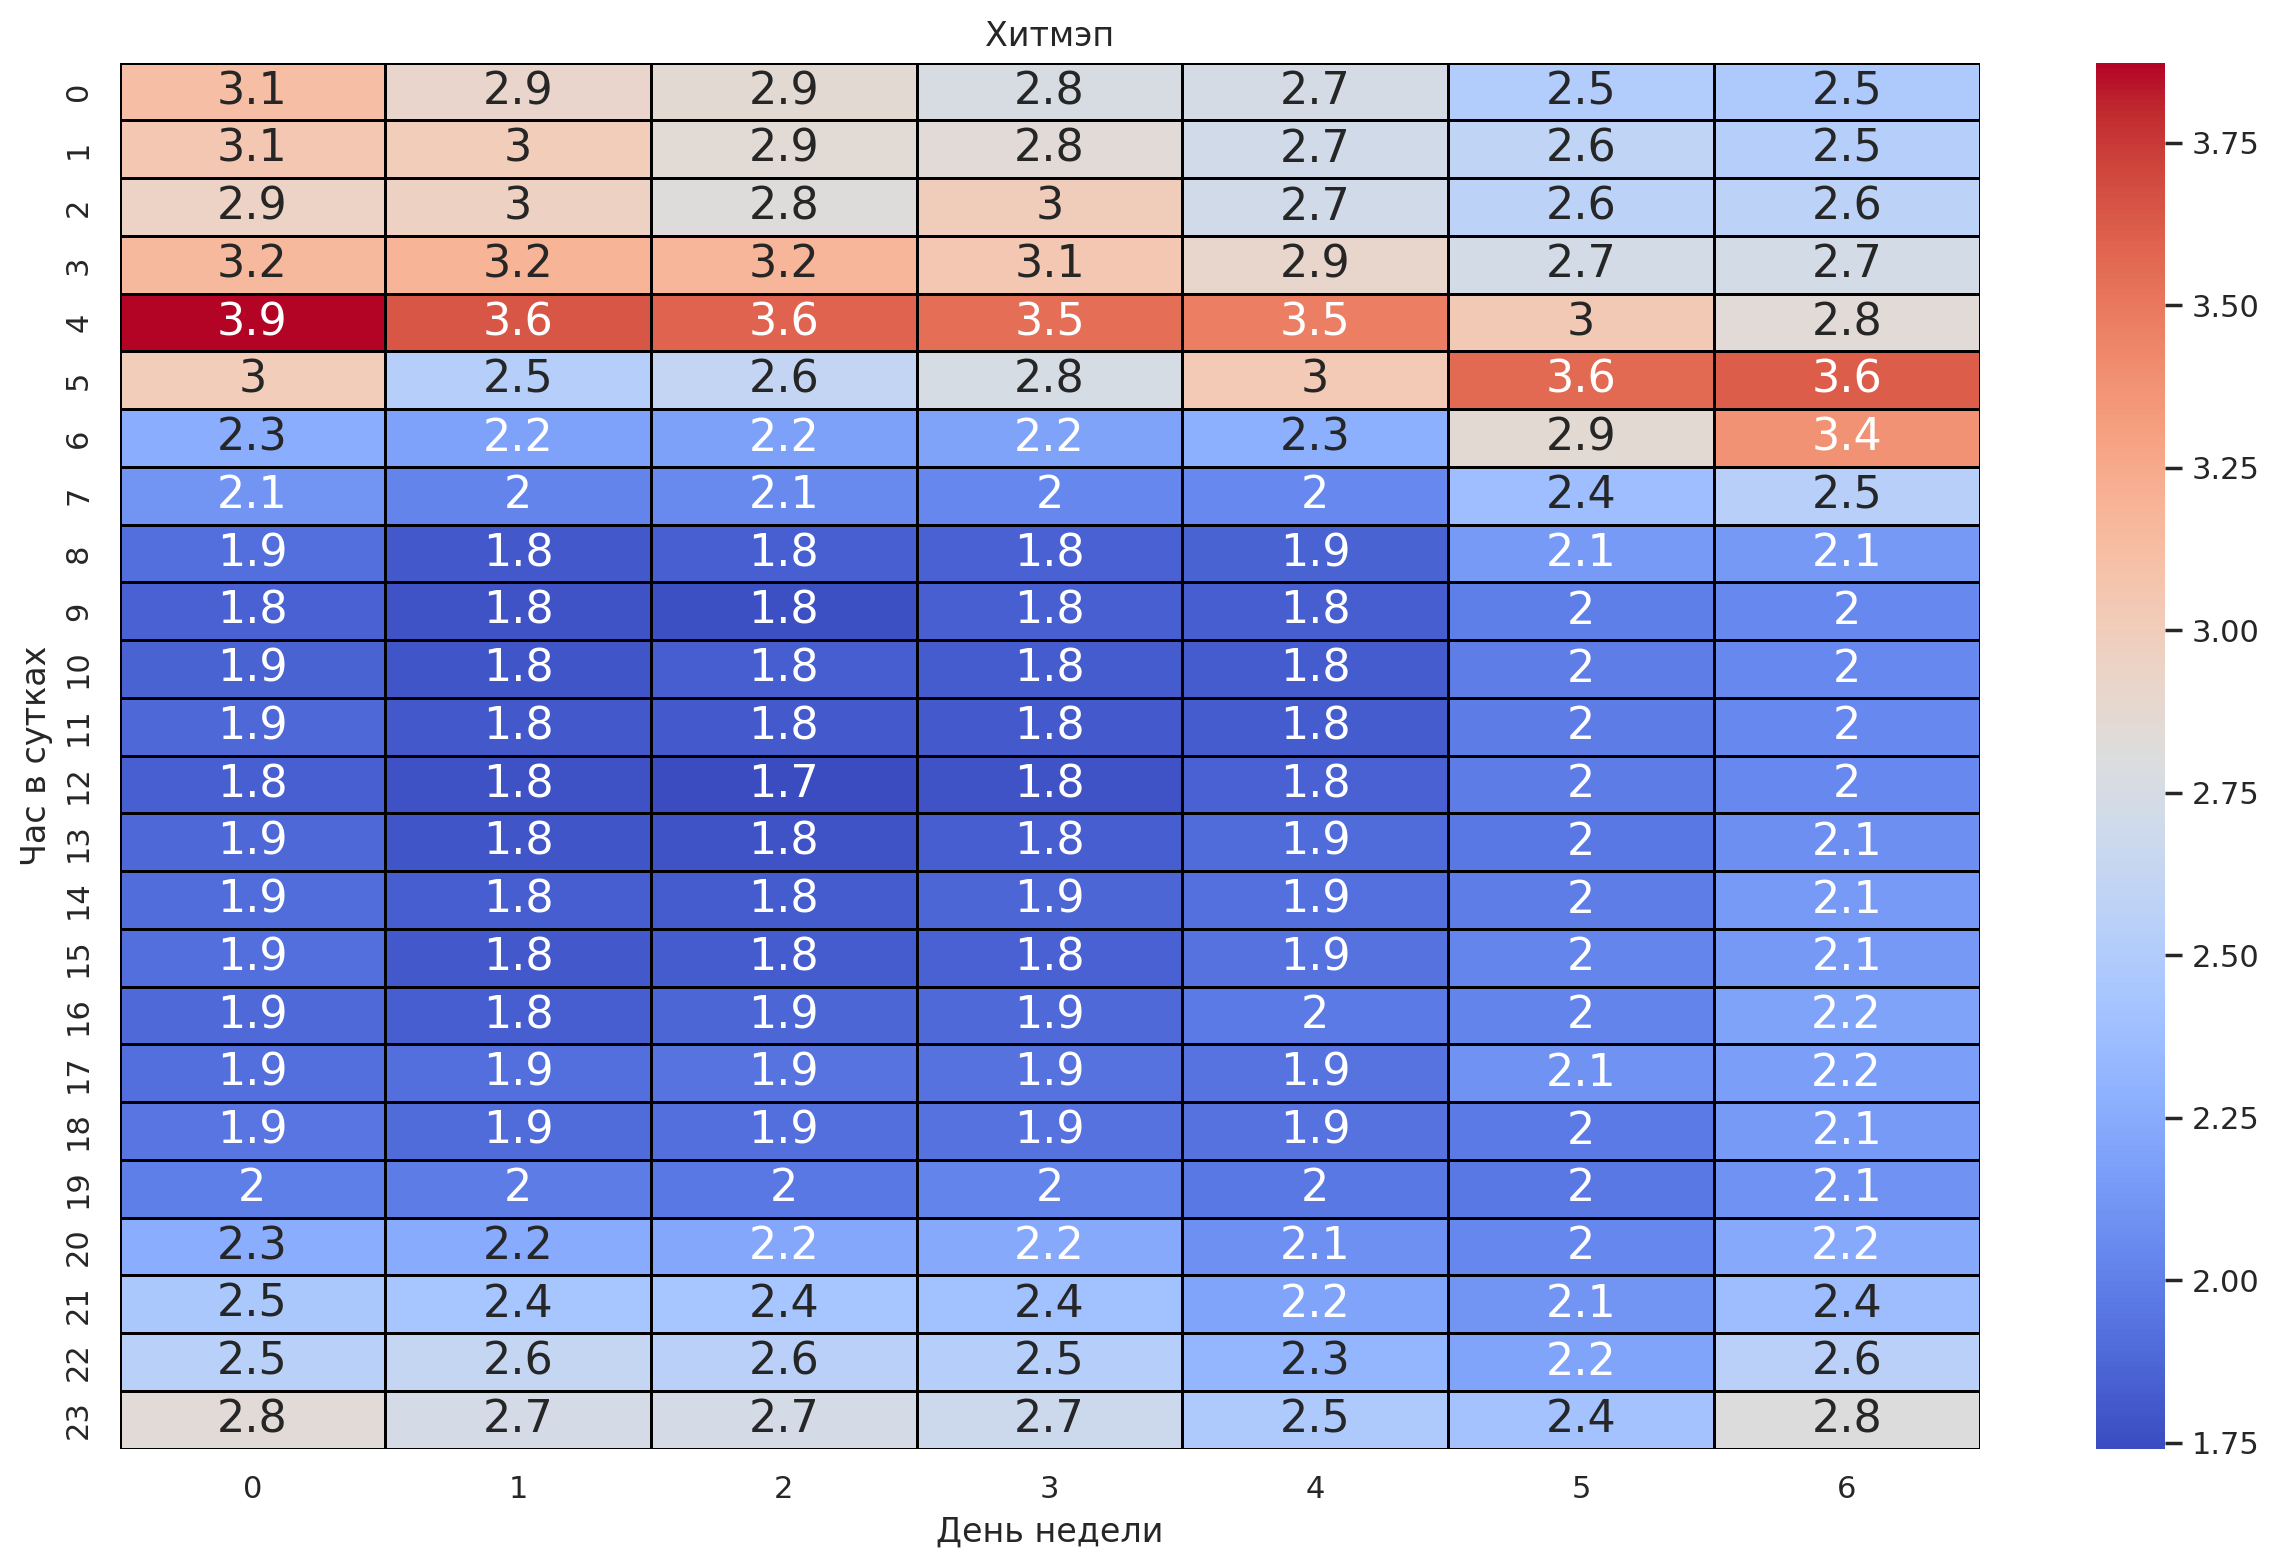

In [204]:
table = pd.pivot_table(df, values='haversine', index='hour', columns='pickup_day_week',
                       aggfunc={'haversine': np.median})

sns.heatmap(table, annot=True, cmap= 'coolwarm',  linewidths=.5, linecolor='black')

plt.title('Хитмэп')
plt.xlabel('День недели')
plt.ylabel('Час в сутках')

plt.show()


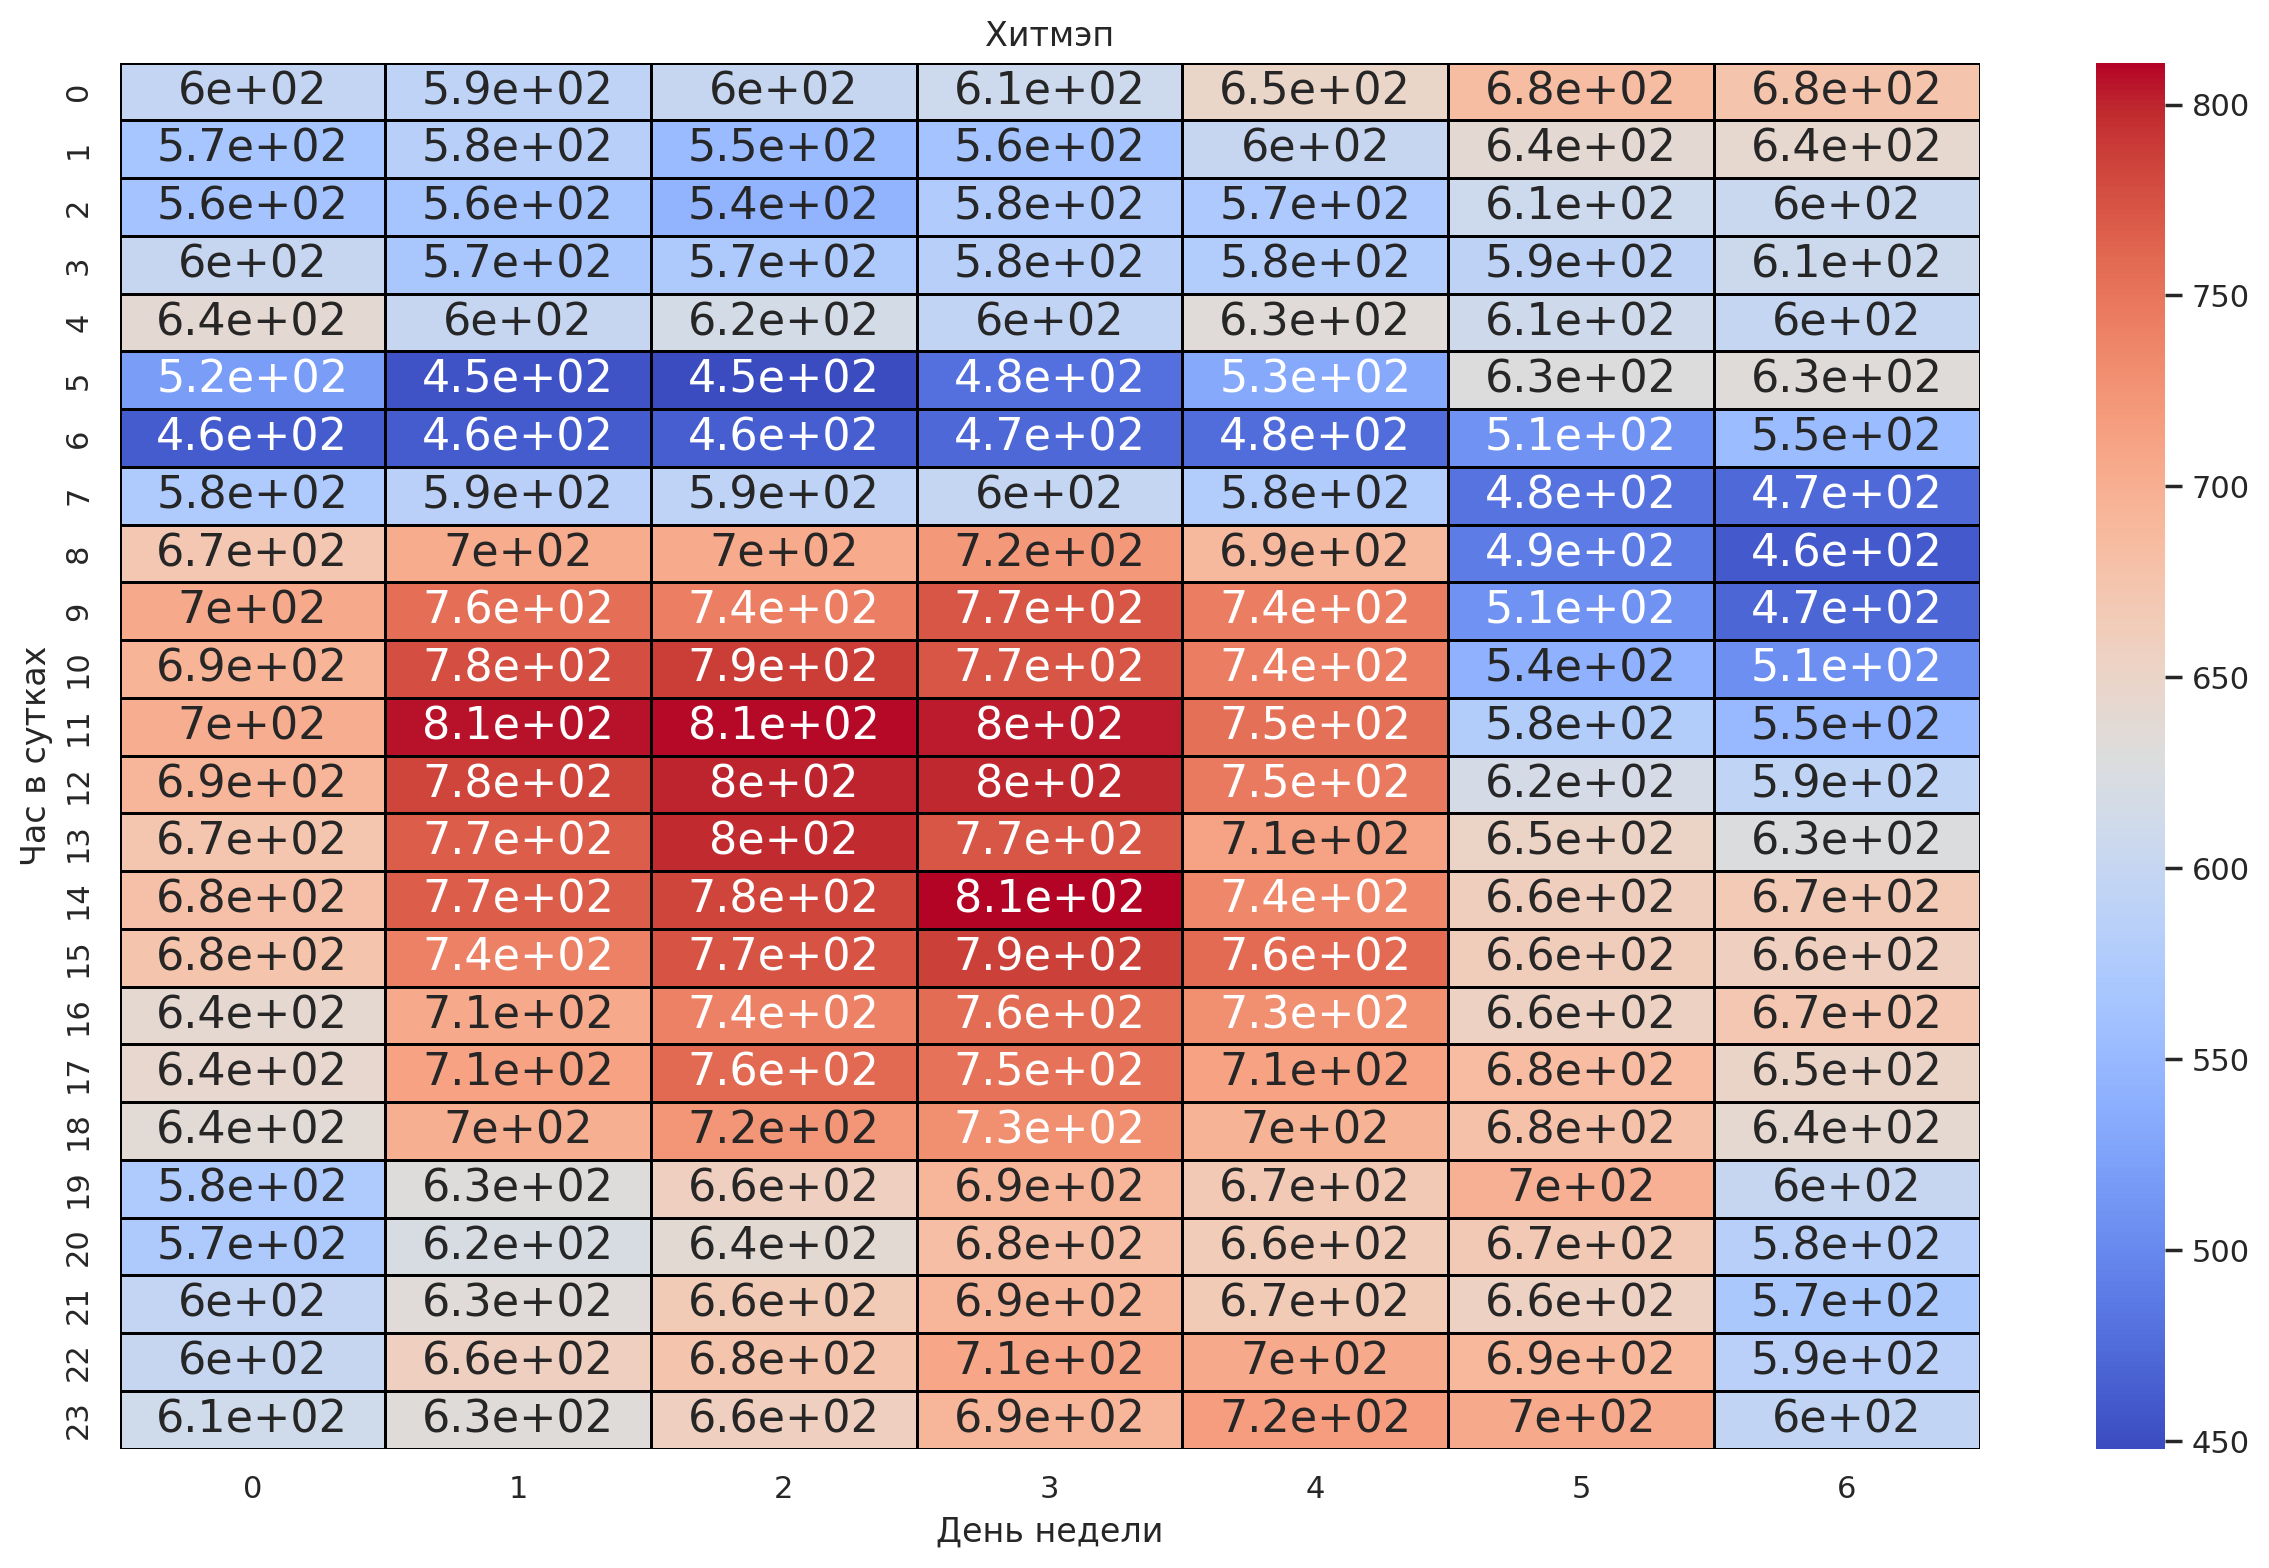

In [211]:
table = pd.pivot_table(df, values='trip_duration', index='hour', columns='pickup_day_week',
                       aggfunc={'trip_duration': np.median})

sns.heatmap(table, annot=True, cmap= 'coolwarm',  linewidths=.5, linecolor='black')

plt.title('Хитмэп')
plt.xlabel('День недели')
plt.ylabel('Час в сутках')

plt.show()

Если сравнить два этих хитмэпа, то можно увидеть, когда возникают пробки. Потому что мы отчетливо видим, что наибольшее время поездке не соотвествует максимально пройденным расстояниям.


In [184]:
# n = 1458644
# m = 1

# k1 = m
# k2 = n - m - 1

# k1, k2

# alpha = 0.05

# t = stats.f.ppf(1 - alpha, k1, k2)
# t

In [185]:
# F = (R / k1) / ((1 - R) / k2)
# F

In [186]:
# b1 = np.cov(df['passenger_count'], df['trip_duration'], ddof=1)[0, 1] / np.var(df['passenger_count'], ddof=1)
# b0 = df['trip_duration'].mean() - b1 * df['passenger_count'].mean()

In [187]:
# plt.scatter(df['passenger_count'], df['trip_duration'])
# x = np.linspace(0, 10, 1000)
# y = b0*x + b1
# plt.plot(x, y, color = 'r')
# plt.show()

Вывод: вполне очевидно, что самый сильный признак для подсчета длительности поездки - пройденное расстояние и у них примерно одинаковое распределение, логнормальное, что для меня было не очевидно. Так же дата зачастую тоже может быть значимым признаком. Так, по четвергам и пятницам в среднем поездка будет длиться дольше из-за пробок. Выяснили, что до пятницы стабильно увеличивается количество поездок на такси по дням недели, а от пятницы до воскрсенья снижается. Скорее всего, это связано с тем, что люди к концу недели всё больше не хотят пользоваться общественным транспортом, так как накапливается определенная усталость, а в выходные темп снижается и многим людям просто нет необходимости пользоваться такси.  Так же до 20 часов время пользования такси увеличивается, а потом уменьшается, что логично, так как ночью большинство спят:)
От количества пассажиров, оказывается, время поездки не зависит, что тоже не совсем очевидно.